In [6]:
import numpy as np
import gym
import time
import math
import random
import torch
from torch.autograd import Variable
from tqdm import tqdm
import copy
from IPython.display import clear_output
from matplotlib import image
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns

  0%|                                                                                                                                 | 0/1000 [00:00<?, ?it/s]

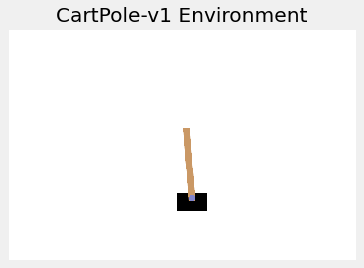

  5%|██████▍                                                                                                                | 54/1000 [00:00<00:04, 232.81it/s]


In [84]:
env = gym.envs.make("CartPole-v1")

def get_screen(screen=None):
    ''' Extract one step of the simulation.'''
    if screen is None:
        screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

def save_and_get_screen(screen=None):
    ''' Extract one step of the simulation.'''
    if screen is None:
        screen = env.render(mode='rgb_array').transpose((2, 0, 1))
        np.save("/data/localhost/taufiq/export-dir/cartpole_env_<-1.5", screen)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Speify the number of simulation steps
num_steps = 1000
env.reset()

# Show several steps
clear_output(wait=True)
observation, _, done, _ = env.reset()
for i in tqdm(range(num_steps)):
    if done:
        env.reset()
    observation, _, done, _ = env.step(env.action_space.sample())
    pole_angle = observation[2]
    angular_vel = observation[3]
    if angular_vel < -1.5:
        plt.figure()
        plt.imshow(save_and_get_screen().cpu().permute(1, 2, 0).numpy(),
                   interpolation='none')
        plt.grid(True)
        plt.style.use('fivethirtyeight')
        plt.title('CartPole-v1 Environment')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        break

In [57]:
observation, reward, done, info = env.step(env.action_space.sample())

In [50]:
observation

array([ 0.02566209,  0.22550201,  0.00645293, -0.2492753 ], dtype=float32)

In [72]:
# Demonstration
import matplotlib.pyplot as plt

env = gym.envs.make("CartPole-v1")

def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [6]:
class DQL():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.target = copy.deepcopy(self.model)

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

In [7]:
def q_learning(env, model, episodes, gamma=0.9, epsilon=0.3, eps_decay=0.99, replay=False, replay_size=20, title = 'DQL', double=False, n_update=10, soft=False):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    for episode in range(episodes):
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break
                if replay:
                    # Update network weights using replay memory
                    model.replay(memory, replay_size, gamma)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)
            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
    return final

In [540]:
env = gym.envs.make("CartPole-v1")
model = DQL(state_dim=4, action_dim=2, hidden_dim=50, lr=0.001)
final = q_learning(env, model, episodes=500,
                   gamma=1.0, epsilon=0.2, replay=False, double=False,
                   title='DQL with Replay', n_update=20)

## Save trained policy state

In [32]:
# torch.save(model.model.state_dict(), "/data/localhost/taufiq/export-dir/cartpole-models/obs-pol-state")

<All keys matched successfully>

## Load saved policy state

In [34]:
model = DQL(state_dim=4, action_dim=2, hidden_dim=50, lr=0.001)
model.model.load_state_dict(torch.load("/data/localhost/taufiq/export-dir/cartpole-models/obs-pol-state"))

<All keys matched successfully>

In [33]:
state = env.reset()
model.predict(state)

tensor([467.0031, 478.0294])

In [46]:
df_check = pd.DataFrame()
episodes = 10
epsilon = 0.1
for i in tqdm(range(episodes)):
    done = False
    state = env.reset()
    t=0
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = model.predict(state).argmax().item()
        df_check = df_check.append({'episode': i, 't': t,'Cart Position': state[0], 'Cart Velocity': state[1], 'Pole Angle': state[2], 'Pole Angular Velocity': state[3], 'A': action}, ignore_index=True)
        state, reward, done, _ = env.step(action)
        t += 1

100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


In [47]:
df_check[df_check['t']==100]

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t
100,0.0,-0.842589,-0.022185,0.031249,-0.390021,0.0,100.0
600,0.0,-0.801931,-0.332884,0.021073,-0.116868,1.0,100.0
1100,1.0,-0.679091,-0.313419,0.048557,-0.087991,2.0,100.0
1600,0.0,-0.837507,-0.395491,0.035215,-0.024968,3.0,100.0
2100,0.0,-0.754121,-0.353810,0.034592,-0.073106,4.0,100.0
2600,0.0,-0.680662,-0.340622,0.004515,-0.001456,5.0,100.0
3100,1.0,-0.811648,-0.404388,0.014476,0.133263,6.0,100.0
3600,1.0,-0.718980,-0.417532,0.010861,0.068231,7.0,100.0
4100,1.0,-0.689429,-0.743746,0.008160,0.445810,8.0,100.0
4600,0.0,-0.747482,-0.408304,0.023860,-0.057315,9.0,100.0


In [38]:
len(df_check)

4525

In [ ]:
episodes = 1000
for j in tqdm(range(10)):
    df = pd.DataFrame()
    epsilon = 0.1
    for i in tqdm(range(j*episodes, (j+1)*episodes)):
        done = False
        state = env.reset()
        t=0
        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = model.predict(state).argmax().item()
            df = df.append({'episode': i, 't': t,'Cart Position': state[0], 'Cart Velocity': state[1], 'Pole Angle': state[2], 'Pole Angular Velocity': state[3], 'A': action}, ignore_index=True)
            state, reward, done, _ = env.step(action)
            t += 1
    df.to_csv(f"/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-{j}.csv", index=False)

In [27]:
df.to_csv(f"/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-0.csv", index=False)

In [4]:
# df.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data.csv", index=False)
df = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data.csv")

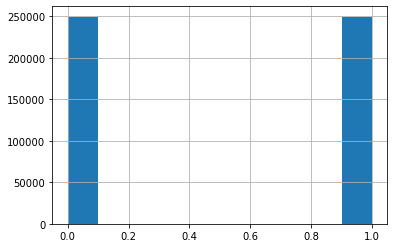

In [5]:
df['A'].hist()

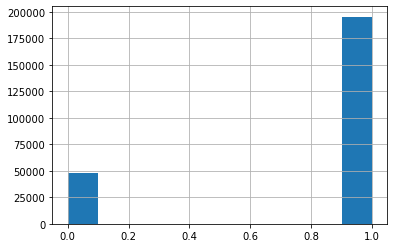

In [6]:
# df.loc[(df['Pole Angular Velocity']>0) & (df['Cart Velocity']>0), 'A'].hist()
df.loc[(df['Pole Angular Velocity']>0), 'A'].hist()

In [7]:
df.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t
0,0.0,-0.044931,0.005088,0.000109,-0.033541,0.0,0.0
1,1.0,-0.044829,-0.190036,-0.000562,0.259176,0.0,1.0
2,0.0,-0.048630,0.005094,0.004621,-0.033684,0.0,2.0
3,1.0,-0.048528,-0.190094,0.003948,0.260453,0.0,3.0
4,0.0,-0.052330,0.004971,0.009157,-0.030982,0.0,4.0


In [148]:
PATH="/data/localhost/taufiq/export-dir/cartpole/cartpole_state_dicts"
torch.save({
    'model_state_dict': model.model.state_dict(),
    'optimizer_state_dict': model.optimizer.state_dict()
}, PATH)

# Remove the sign of angular velocity

We define the unobserved confounder $U$ to be the sign of Angular velocity

In [8]:
df_partial = df.copy()
# df_partial['Pole Angular Velocity (sign)'] = (df_partial['Pole Angular Velocity']>=0)*1 - (df_partial['Pole Angular Velocity']<0)*1
# df_partial['Cart Velocity (sign)'] = (df_partial['Cart Velocity']>=0)*1 - (df_partial['Cart Velocity']<0)*1
# df_partial['Pole Angular Velocity'] = df_partial['Pole Angular Velocity'].abs()
# df_partial['Cart Velocity'] = df_partial['Cart Velocity'].abs()
# df_partial.rename(columns={'Pole Angular Velocity': 'Pole Angular Velocity (abs)', 'Cart Velocity': 'Cart Velocity (abs)'}, inplace=True)
# df_partial.head()


In [9]:
# x_columns = ['Cart Position', 'Cart Velocity (abs)', 'Pole Angle', 'Pole Angular Velocity (abs)']
x_columns = ['Cart Position', 'Pole Angle']
rename_cols_t1 = {k: f'{k}_t1' for k in x_columns}

In [240]:
# sim_data = pd.DataFrame()
# for episode in tqdm(range(0,500)):
#     df_filtered_t0 = df_partial.loc[df_partial['episode']==episode].copy().iloc[:-1].reset_index(drop=True)
#     df_filtered_t1 = df_partial.loc[df_partial['episode']==episode].copy().iloc[1:][x_columns].rename(columns=rename_cols_t1).reset_index(drop=True)
#     df_episode = pd.merge(df_filtered_t0, df_filtered_t1, left_index=True, right_index=True)
#     sim_data = sim_data.append(df_episode, ignore_index=True)

100%|██████████| 500/500 [00:03<00:00, 129.76it/s]


In [10]:
obs_data = pd.DataFrame()
for episode in tqdm(range(500,1000)):
    df_filtered_t0 = df_partial.loc[df_partial['episode']==episode].copy().iloc[:-1].reset_index(drop=True)
    df_filtered_t1 = df_partial.loc[df_partial['episode']==episode].copy().iloc[1:][x_columns].rename(columns=rename_cols_t1).reset_index(drop=True)
    df_episode = pd.merge(df_filtered_t0, df_filtered_t1, left_index=True, right_index=True)
    obs_data = obs_data.append(df_episode, ignore_index=True)

100%|██████████| 500/500 [00:02<00:00, 245.81it/s]


In [11]:
len(obs_data)

249500

# Confounding
To induce confounding, we only include transitions with angular velocity <= 0 in observational data.

In [15]:
select = np.random.uniform(0, 1, len(sim_data_combined))
sim_data_filtered = sim_data_combined.loc[select < 0.5]


In [663]:
select = np.random.uniform(0, 1, len(obs_data))
obs_data = obs_data.loc[~(obs_data['Pole Angular Velocity']>0)]
# obs_data = obs_data.loc[(select < 0.5)]


In [670]:
len(obs_data)

126311

In [665]:
random_arr = np.random.uniform(0, 1, len(obs_data))
obs_data_train = obs_data[random_arr <= 0.8].copy()
obs_data_test = obs_data[random_arr > 0.8].copy()

In [248]:
(sim_data_filtered['Pole Angular Velocity (sign)']==-1).sum()

64188

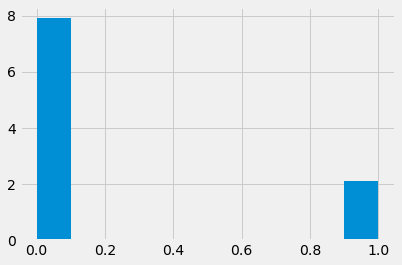

In [110]:
obs_data_train['A'].hist(density=True)

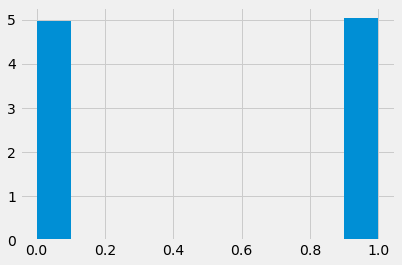

In [185]:
sim_data_filtered['A'].hist(density=True)

# Generate $Y(a)$ Data using random policy

In [453]:
sim_data = pd.DataFrame()
episodes = 4000
for i in tqdm(range(episodes)):
    done = False
    state = env.reset()
    t=0
    while not done:
        action = env.action_space.sample()
        sim_data = sim_data.append({'episode': i, 't': t,'Cart Position': state[0], 'Cart Velocity': state[1], 'Pole Angle': state[2], 'Pole Angular Velocity': state[3], 'A': action}, ignore_index=True)
        state, reward, done, _ = env.step(action)
        t += 1

100%|██████████| 4000/4000 [01:32<00:00, 43.37it/s]


In [454]:
len(sim_data)

87453

In [180]:
sim_data['Pole Angular Velocity (sign)'] = (sim_data['Pole Angular Velocity']>=0)*1 - (sim_data['Pole Angular Velocity']<0)*1
sim_data['Cart Velocity (sign)'] = (sim_data['Cart Velocity']>=0)*1 - (sim_data['Cart Velocity']<0)*1
sim_data['Pole Angular Velocity'] = sim_data['Pole Angular Velocity'].abs()
sim_data['Cart Velocity'] = sim_data['Cart Velocity'].abs()
sim_data.rename(columns={'Pole Angular Velocity': 'Pole Angular Velocity (abs)', 'Cart Velocity': 'Cart Velocity (abs)'}, inplace=True)
sim_data.head()

,A,Cart Position,Cart Velocity (abs),Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Velocity (sign)
0,0.0,0.006463,0.019312,-0.008931,0.003310,0.0,0.0,-1,-1
1,0.0,0.006077,0.214305,-0.008997,0.286542,0.0,1.0,1,-1
2,1.0,0.001791,0.409297,-0.003266,0.576374,0.0,2.0,1,-1
3,0.0,-0.006395,0.214129,0.008261,0.282664,0.0,3.0,1,-1
4,1.0,-0.010677,0.409368,0.013915,0.577941,0.0,4.0,1,-1


In [472]:
episodes = sim_data['episode'].unique()
sim_data_combined = pd.DataFrame()
for episode in tqdm(episodes):
    df_filtered_t0 = sim_data.loc[sim_data['episode']==episode].copy().iloc[:-1].reset_index(drop=True)
    df_filtered_t1 = sim_data.loc[sim_data['episode']==episode].copy().iloc[1:][x_columns].rename(columns=rename_cols_t1).reset_index(drop=True)
    df_episode = pd.merge(df_filtered_t0, df_filtered_t1, left_index=True, right_index=True)
    sim_data_combined = sim_data_combined.append(df_episode, ignore_index=True)
    
sim_data_filtered = sim_data_combined.copy()

In [12]:
sim_data_combined.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-sim-data-rand-policy.csv", index=False)

In [61]:
# obs_data_train.to_csv("/data/localhost/taufiq/export-dir/cartpole_data_x_no_velocity/Cartpole-v1-obs-data-train.csv", index=False)
# obs_data_test.to_csv("/data/localhost/taufiq/export-dir/cartpole_data_x_no_velocity/Cartpole-v1-obs-data-test.csv", index=False)
# sim_data_filtered.to_csv("/data/localhost/taufiq/export-dir/cartpole_data_x_no_velocity/Cartpole-v1-sim-data.csv", index=False)

obs_data_train = pd.read_csv("/data/localhost/taufiq/export-dir/cartpole_data_x_no_velocity/Cartpole-v1-obs-data-train.csv")
obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/cartpole_data_x_no_velocity/Cartpole-v1-obs-data-test.csv")
sim_data_filtered = pd.read_csv("/data/localhost/taufiq/export-dir/cartpole_data_x_no_velocity/Cartpole-v1-sim-data-rand-policy.csv")

In [13]:
(obs_data_train['Pole Angular Velocity']>=0).sum()
sim_data_filtered.to_csv("/data/localhost/taufiq/paper_datasets/DT1_data.csv", index=False)

In [14]:
obs_data_train.to_csv("/data/localhost/taufiq/paper_datasets/CartPole_obs_data.csv", index=False) 

In [11]:
sim_data_dt2 = sim_data_filtered.copy()
sim_data_dt2['Pole Angle_t1'] -= 0.005*(sim_data_dt2['Pole Angular Velocity (sign)']==1)
sim_data_dt2.to_csv("/data/localhost/taufiq/paper_datasets/DT2_data.csv", index=False)

In [12]:
sim_data_dt3 = sim_data_filtered.copy()
sim_data_dt3['Pole Angle_t1'] -= 0.007
sim_data_dt3.to_csv("/data/localhost/taufiq/paper_datasets/DT3_data.csv", index=False)

In [62]:
quantile_data = sim_data_filtered.copy()

# Train policy $\pi(A\mid X)$

In [11]:
import torch.utils.data as data_utils

class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_1_dim=3):
        super(PolicyNetwork, self).__init__()
        self.hid1 = torch.nn.Linear(input_dim, hidden_1_dim)
        self.outp = torch.nn.Linear(hidden_1_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.outp.weight)
        torch.nn.init.zeros_(self.outp.bias)

    def forward(self, x):
        z = self.tanh(self.hid1(x))
        z = self.outp(z)
        return z

In [1219]:
# x_columns = ['Cart Position', 'Pole Angle']
x_columns = ['Pole Angular Velocity', 'Pole Angle']

obs_data_raw = (obs_data_train[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [1220]:
grp = np.floor(5*np.random.rand(len(obs_data_train))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(obs_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(obs_data_raw.loc[testidx].values)
Y = torch.tensor(obs_data_train.loc[trainidx, 'A'].values).to(torch.long)
Ytest = torch.tensor(obs_data_train.loc[testidx, 'A'].values).to(torch.long)

train = data_utils.TensorDataset(X, Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(Xtest, Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=len(obs_data_raw.columns), output_dim=2)
optimizer = torch.optim.Adam(policy.parameters(), lr=0.001, weight_decay=0)
losses = []

In [1221]:
for epoch in tqdm(range(100)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


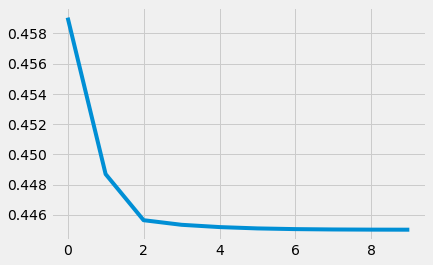

In [1222]:
plt.plot(losses)

In [1223]:
softmax = torch.nn.Softmax(dim=1)

softmax(policy(Xtest[:10,:]))

tensor([[0.5594, 0.4406],
        [0.2598, 0.7402],
        [0.9084, 0.0916],
        [0.8675, 0.1325],
        [0.0897, 0.9103],
        [0.1981, 0.8019],
        [0.5995, 0.4005],
        [0.1481, 0.8519],
        [0.8355, 0.1645],
        [0.0898, 0.9102]], grad_fn=<SoftmaxBackward>)

0.5685

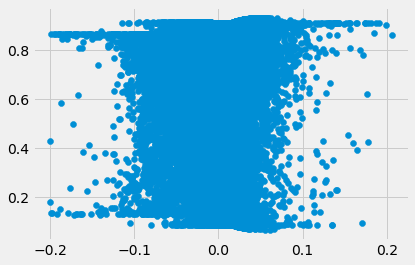

In [1224]:
a_ = torch.tensor(obs_data_train['A'].values).long()
pol_val = softmax(policy(torch.FloatTensor(obs_data_raw[x_columns].values)))[torch.arange(len(obs_data_train)),a_].detach().numpy()

plt.scatter(obs_data_train['Pole Angle'], pol_val)
(pol_val>0.8).mean()


In [270]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(Xtest)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += Xtest.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 79 %


In [261]:
PATH="/data/localhost/taufiq/export-dir/cartpole/policy_dicts"
torch.save({
    'model_state_dict': policy.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

In [30]:
checkpoint = torch.load(PATH)
policy.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Train $\mathbb{E}[Y \mid x, a]$

In [4]:
outcome = "Pole Angle"

In [3]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.leakyRelu = torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.leakyRelu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [1752]:
x_columns = ['Pole Angular Velocity', 'Pole Angle']

grp = np.floor(5*np.random.rand(len(obs_data_train))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(obs_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(obs_data_raw.loc[testidx].values)
A = torch.FloatTensor(obs_data_train.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(obs_data_train.loc[testidx, 'A'].values)

Y = torch.FloatTensor((obs_data_train.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((obs_data_train.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
obs_net = Net2(n_feature=len(obs_data_raw.columns)+1, n_hidden=4, n_hidden2=4, n_output=1)
optimizer = torch.optim.SGD(obs_net.parameters(), lr=0.001)
losses = []

In [1753]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = obs_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(obs_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


In [1754]:
losses[-1]

0.008454138413071632

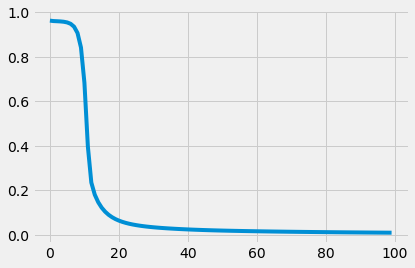

In [1755]:
plt.plot(losses)

In [267]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_obs_dicts"
torch.save({
    'model_state_dict': obs_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

In [36]:
checkpoint = torch.load(PATH)
obs_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Train $\mathbb{E}[Y_{max}\mid x, a]$

In [9]:
class PinballLoss():
    def __init__(self, quantile=0.10, reduction='none'):
        self.quantile = quantile
        assert 0 < self.quantile
        assert self.quantile < 1
        self.reduction = reduction

    def __call__(self, output, target):
        assert output.shape == target.shape
        loss = torch.zeros_like(target, dtype=torch.float)
        error = output - target
        smaller_index = error < 0
        bigger_index = 0 < error
        loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
        loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])

        if self.reduction == 'sum':
            loss = loss.sum()
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [171]:
quantile_data_raw = (quantile_data[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [1672]:
grp = np.floor(5*np.random.rand(len(obs_data_train))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(obs_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(obs_data_raw.loc[testidx].values)
A = torch.FloatTensor(obs_data_train.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(obs_data_train.loc[testidx, 'A'].values)

Y = torch.FloatTensor((obs_data_train.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((obs_data_train.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = PinballLoss(quantile=0.975, reduction='mean')
ymax_net = Net2(n_feature=len(obs_data_raw.columns) + 1, n_hidden=4, n_hidden2=4, n_output=1)
optimizer = torch.optim.SGD(ymax_net.parameters(), lr=0.001)
losses = []

In [1673]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = ymax_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(ymax_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


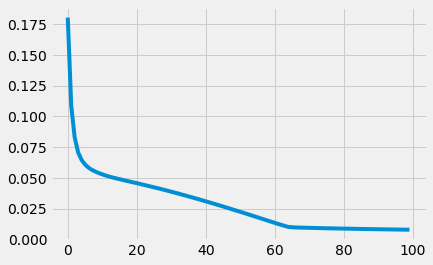

In [1674]:
plt.plot(losses)

In [330]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_max_dicts"
torch.save({
    'model_state_dict': ymax_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

# Train $\mathbb{E}[Y_{min}\mid x, a]$

In [1675]:
loss_func = PinballLoss(quantile=0.025, reduction='mean')
ymin_net = Net2(n_feature=len(obs_data_raw.columns) + 1, n_hidden=4, n_hidden2=4, n_output=1)
optimizer = torch.optim.SGD(ymin_net.parameters(), lr=0.005)
losses = []

In [1676]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = ymin_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(ymin_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


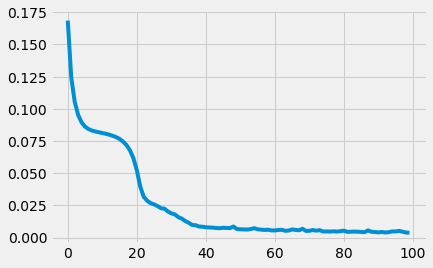

In [1677]:
plt.plot(losses)

In [334]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_min_dicts"
torch.save({
    'model_state_dict': ymax_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

# Train $\mathbb{E}[Y^{sim}(a) \mid x(a)]$

In [358]:
sim_data = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-sim-data-iid.csv")
sim_data_filtered = sim_data.copy()
sim_data_raw = (sim_data_filtered[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()


In [360]:
grp = np.floor(5*np.random.rand(len(sim_data_filtered))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(sim_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(sim_data_raw.loc[testidx].values)
A = torch.FloatTensor(sim_data_filtered.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(sim_data_filtered.loc[testidx, 'A'].values)

Y = torch.FloatTensor((sim_data_filtered.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((sim_data_filtered.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
# sim_net = Net(n_feature=len(sim_data_raw.columns)+1, n_hidden=8, n_output=1)
sim_net = Net2(n_feature=len(sim_data_raw.columns) + 1, n_hidden=4, n_hidden2=4, n_output=1)
optimizer = torch.optim.SGD(sim_net.parameters(), lr=0.001)
losses = []

In [361]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = sim_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(sim_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


In [362]:
losses[-1]

0.00014244852354750037

In [363]:
losses[-1]

0.00014244852354750037

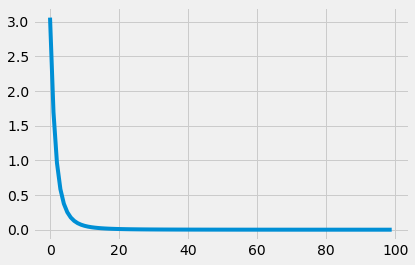

In [364]:
plt.plot(losses)

In [293]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_sim_dicts"
torch.save({
    'model_state_dict': sim_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

In [40]:
checkpoint = torch.load(PATH)
sim_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [28]:
# sim_data.head()

# Compare MSE with Scores

In [640]:
obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [641]:
obs_data_test_copy = obs_data_test.copy()
with torch.no_grad():
    X_val = torch.FloatTensor(obs_data_test_raw.values) 
    A_val = torch.FloatTensor(obs_data_test['A'].values)
    pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    sim_pred = sim_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
    mse = torch.square(sim_pred - Y)
    pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
    ymin = ymin_net(X_val).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    ymax = ymax_net(X_val).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    obs_data_test_copy['MSE'] = mse.numpy()
    obs_data_test_copy['LB'] = (pred*pol_val + (1-pol_val)*ymin).numpy()
    obs_data_test_copy['UB'] = (pred*pol_val + (1-pol_val)*ymax).numpy()
    obs_data_test_copy[f'Sim_{outcome}_t1'] = sim_pred.numpy()
    obs_data_test_copy['In bounds'] = (obs_data_test_copy['LB'] <= obs_data_test_copy[f'Sim_{outcome}_t1']).apply(int) * (obs_data_test_copy['UB'] >= obs_data_test_copy[f'Sim_{outcome}_t1']).apply(int)
    obs_data_test_copy['Bound length'] = obs_data_test_copy['UB'] - obs_data_test_copy['LB']
    

In [642]:
obs_data_test_copy.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t,Cart Position_t1,Pole Angle_t1,MSE,LB,UB,Sim_Pole Angle_t1,In bounds,Bound length
12,0.0,-0.004923,-0.028104,0.018981,-0.039786,500.0,12.0,-0.005485,0.018185,0.000014,0.002865,0.034352,0.021971,1,0.031486
16,1.0,-0.015009,-0.029295,0.028238,-0.013511,500.0,16.0,-0.015595,0.027968,0.000022,0.006608,0.057329,0.032685,1,0.050721
19,0.0,-0.012889,0.164700,0.022110,-0.281435,500.0,19.0,-0.009595,0.016481,0.000088,0.004301,0.039975,0.025884,1,0.035674
21,0.0,-0.010210,0.164152,0.016844,-0.269299,500.0,21.0,-0.006927,0.011458,0.000069,0.002317,0.030074,0.019744,1,0.027757
33,0.0,-0.002180,0.163466,0.002310,-0.254127,500.0,33.0,0.001089,-0.002773,0.000031,-0.007338,0.004173,0.002769,1,0.011512


In [643]:
obs_data_test_copy.loc[obs_data_test_copy['A']==0, 'MSE'].mean()

4.012128192698583e-05

In [644]:
obs_data_test_copy.loc[obs_data_test_copy['A']==1, 'MSE'].mean()

2.4464923626510426e-05

In [645]:
p0 = ((obs_data_test_copy['In bounds']==1) & (obs_data_test_copy['A']==0)).sum()/(obs_data_test_copy['A']==0).sum()
p1 = ((obs_data_test_copy['In bounds']==1) & (obs_data_test_copy['A']==1)).sum()/(obs_data_test_copy['A']==1).sum()
print(f'p_0 = {p0}$')
print(f'p_1 = {p1}$')

p_0 = 0.6529117807134729$
p_1 = 1.0$


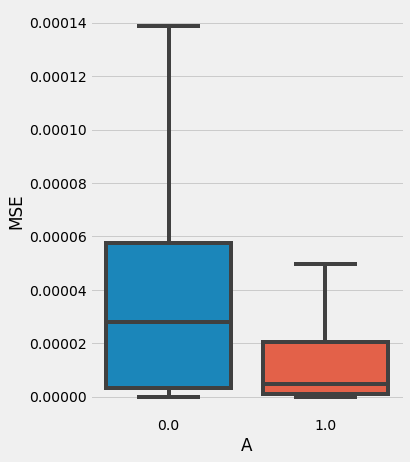

In [646]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(5,7))
sns.boxplot(y='MSE',x='A', data=obs_data_test_copy.astype({'A': 'str'}), ax=axs, showfliers=False)

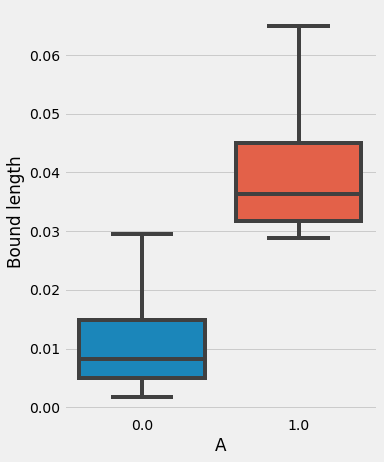

In [647]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(5,7))
sns.boxplot(y='Bound length',x='A', data=obs_data_test_copy.astype({'A': 'str'}), ax=axs, showfliers=False)

# Simulator 2: wrong model

Simulator 2 is wrong but should attain lower MSE than previous simulator

In [612]:
sim2_data = sim_data_filtered.copy()

In [613]:
epsilon = 0.005
# sim2_data.loc[sim2_data['Pole Angle'] > 0,'Pole Angle_t1'] -= epsilon
sim2_data.loc[sim2_data['A']==0,'Pole Angle_t1'] -= epsilon
sim2_data.loc[sim2_data['A']==1,'Pole Angle_t1'] += epsilon

In [614]:
sim2_data.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t,Cart Position_t1,Cart Velocity_t1,Pole Angle_t1
0,1.0,0.046372,-0.012572,0.025780,0.041553,0.0,0.0,0.046121,0.182171,0.031611
1,0.0,0.046121,0.182171,0.026611,-0.242886,0.0,1.0,0.049764,-0.013321,0.016754
2,0.0,0.049764,-0.013321,0.021754,0.058071,0.0,2.0,0.049498,-0.208748,0.017915
3,0.0,0.049498,-0.208748,0.022915,0.357537,0.0,3.0,0.045323,-0.404188,0.025066
4,1.0,0.045323,-0.404188,0.030066,0.657356,0.0,4.0,0.037239,-0.209497,0.048213


In [573]:
sim2_data.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-sim2-data.csv", index=False)

# Train $\mathbb{E}[Y^{sim2}(a) \mid x(a)]$

In [291]:
sim2_data_raw = (sim2_data[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [649]:
grp = np.floor(5*np.random.rand(len(sim2_data))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(sim2_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(sim2_data_raw.loc[testidx].values)
A = torch.FloatTensor(sim2_data.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(sim2_data.loc[testidx, 'A'].values)

Y = torch.FloatTensor((sim2_data.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((sim2_data.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
sim2_net = Net(n_feature=len(sim2_data_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(sim2_net.parameters(), lr=0.001)
losses = []

In [650]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = sim2_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(sim2_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


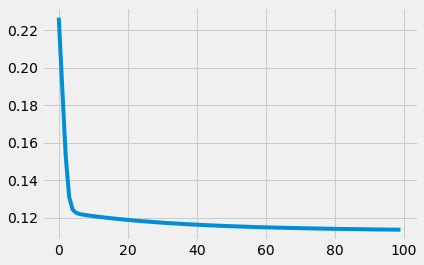

In [232]:
plt.plot(losses)

In [366]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_sim2_dicts"
torch.save({
    'model_state_dict': sim2_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

In [652]:
obs_data_test_copy2 = obs_data_test.copy()
with torch.no_grad():
    X_val = torch.FloatTensor(obs_data_test_raw.values) 
    A_val = torch.FloatTensor(obs_data_test['A'].values)
    pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    sim2_pred = sim2_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
    mse = torch.square(sim2_pred - Y)
    pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
    ymin = ymin_net(X_val).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    ymax = ymax_net(X_val).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    obs_data_test_copy2['MSE'] = mse.numpy()
    obs_data_test_copy2['LB'] = (pred*pol_val + (1-pol_val)*ymin).numpy()
    obs_data_test_copy2['UB'] = (pred*pol_val + (1-pol_val)*ymax).numpy()
    obs_data_test_copy2[f'Sim2_{outcome}_t1'] = sim2_pred.numpy()
    obs_data_test_copy2['In bounds'] = (obs_data_test_copy2['LB'] <= obs_data_test_copy2[f'Sim2_{outcome}_t1']).apply(int) * (obs_data_test_copy2['UB'] >= obs_data_test_copy2[f'Sim2_{outcome}_t1']).apply(int)
    obs_data_test_copy2['Bound length'] = obs_data_test_copy2['UB'] - obs_data_test_copy2['LB']


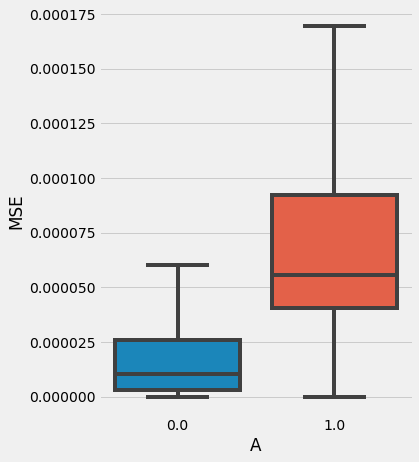

In [653]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(5,7))
sns.boxplot(y='MSE',x='A', data=obs_data_test_copy2.astype({'A': 'str'}), ax=axs, showfliers=False)

In [654]:
p0 = ((obs_data_test_copy2['In bounds']==1) & (obs_data_test_copy2['A']==0)).sum()/(obs_data_test_copy2['A']==0).sum()
p1 = ((obs_data_test_copy2['In bounds']==1) & (obs_data_test_copy2['A']==1)).sum()/(obs_data_test_copy2['A']==1).sum()
print(f'p_0={p0}')
print(f'p_1={p1}')


p_0=0.633961704022562
p_1=1.0


# Analysis of experiment results

In [8]:
nreps = 250
outcome = 'Pole Angle'
obs_data_train = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-train.csv")
df = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data.csv")
x_columns = ['Cart Position', 'Pole Angle']

In [5]:
df_partial = df.copy()


In [10]:
obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-test.csv")
obs_data_test['A'] = obs_data_test['A'].astype({'A': 'int'})
obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (Sim-1)'] = 0
obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (Sim-2)'] = 0
obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (Sim-3)'] = 0
obs_data_test['$\hat{p}^{x,a}$ (Sim-1)'] = 0
obs_data_test['$\hat{p}^{x,a}$ (Sim-2)'] = 0
obs_data_test['$\hat{p}^{x,a}$ (Sim-3)'] = 0

for i in tqdm(range(nreps)):
    models_dir = "/data/localhost/taufiq/cartpole_sim_run2_rand_pol_sim_x_no_velocity/"
    policy = PolicyNetwork(input_dim=len(obs_data_test_raw.columns), output_dim=2)
    policy.load_state_dict(torch.load(f'{models_dir}/policy_{i}'))
    policy.eval()
    obs_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    obs_net.load_state_dict(torch.load(f'{models_dir}/yobs_{i}'))
    obs_net.eval()
    ymin_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    ymin_net.load_state_dict(torch.load(f'{models_dir}/ymin_01_{i}'))
    ymin_net.eval()
    ymax_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    ymax_net.load_state_dict(torch.load(f'{models_dir}/ymax_99_{i}'))
    ymax_net.eval()
    sim_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    sim_net.load_state_dict(torch.load(f'{models_dir}/ysim_{i}'))
    sim_net.eval()
    sim2_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    sim2_net.load_state_dict(torch.load(f'{models_dir}/ysim_false2_{i}'))
    sim2_net.eval()
    sim3_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    sim3_net.load_state_dict(torch.load(f'{models_dir}/ysim_false_{i}'))
    sim3_net.eval()
    
    with torch.no_grad():
        X_val = torch.FloatTensor(obs_data_test_raw.values) 
        A_val = torch.FloatTensor(obs_data_test['A'].values)
        pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
        sim_pred = sim_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
        sim2_pred = sim2_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
        sim3_pred = sim3_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
        Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
        mse = torch.square(sim_pred - Y)
        mse2 = torch.square(sim2_pred - Y)
        mse3 = torch.square(sim3_pred - Y)
        pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
        ymin = ymin_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
        ymax = ymax_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()        
        obs_data_test['pol_val'] = pol_val.numpy()
        obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (Sim-1)'] += mse.numpy()
        obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (Sim-2)'] += mse2.numpy()
        obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (Sim-3)'] += mse3.numpy()
        obs_data_test['LB'] = (pred*pol_val + (1-pol_val)*ymin).numpy()
        obs_data_test['UB'] = (pred*pol_val + (1-pol_val)*ymax).numpy()
        obs_data_test[f'Sim-1_{outcome}_t1'] = sim_pred.numpy()
        obs_data_test['$\hat{p}^{x,a}$ (Sim-1)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-1_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-1_{outcome}_t1']).apply(int)
        obs_data_test[f'Sim-2_{outcome}_t1'] = sim2_pred.numpy()
        obs_data_test['$\hat{p}^{x,a}$ (Sim-2)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-2_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-2_{outcome}_t1']).apply(int)
        obs_data_test[f'Sim-3_{outcome}_t1'] = sim3_pred.numpy()
        obs_data_test['$\hat{p}^{x,a}$ (Sim-3)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-3_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-3_{outcome}_t1']).apply(int)
        obs_data_test['Bound length'] = obs_data_test['UB'] - obs_data_test['LB']
    
obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (Sim-1)'] /= nreps
obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (Sim-2)'] /= nreps
obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (Sim-3)'] /= nreps
obs_data_test['$\hat{p}^{x,a}$ (Sim-1)'] /= nreps
obs_data_test['$\hat{p}^{x,a}$ (Sim-2)'] /= nreps
obs_data_test['$\hat{p}^{x,a}$ (Sim-3)'] /= nreps

100%|██████████| 250/250 [00:11<00:00, 22.53it/s]


In [17]:
obs_data_test.head()

,A,Cart Position,Cart Velocity (abs),Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Velocity (sign),Cart Position_t1,...,"$\hat{p}^{x,a}$ (Sim-1)","$\hat{p}^{x,a}$ (Sim-2)","$\hat{p}^{x,a}$ (Sim-3)",pol_val,LB,UB,Sim-1_Pole Angle_t1,Sim-2_Pole Angle_t1,Sim-3_Pole Angle_t1,Bound length
0,0,0.017909,0.027689,-0.004355,0.048940,500.0,6.0,-1,-1,0.017355,...,0.968,0.036,0.020,0.917415,-0.008736,-0.004870,-0.005678,-0.009632,-0.011239,0.003866
1,0,-0.004923,0.028104,0.018981,0.039786,500.0,12.0,-1,-1,-0.005485,...,1.000,1.000,0.376,0.634503,0.008058,0.025524,0.021839,0.017178,0.016434,0.017466
2,0,-0.002272,0.163339,0.003266,0.251321,500.0,27.0,-1,1,0.000995,...,1.000,1.000,0.168,0.714456,-0.006338,0.007580,0.003615,-0.000303,-0.002506,0.013918
3,0,-0.002180,0.163466,0.002310,0.254127,500.0,33.0,-1,1,0.001089,...,0.988,1.000,0.156,0.765071,-0.006212,0.005213,0.002559,-0.001364,-0.003435,0.011425
4,0,0.010897,0.163602,-0.018024,0.257135,500.0,37.0,-1,1,0.014169,...,0.948,0.036,0.020,0.940501,-0.022764,-0.020347,-0.020425,-0.025447,-0.025721,0.002416


(0.0, 1.01)

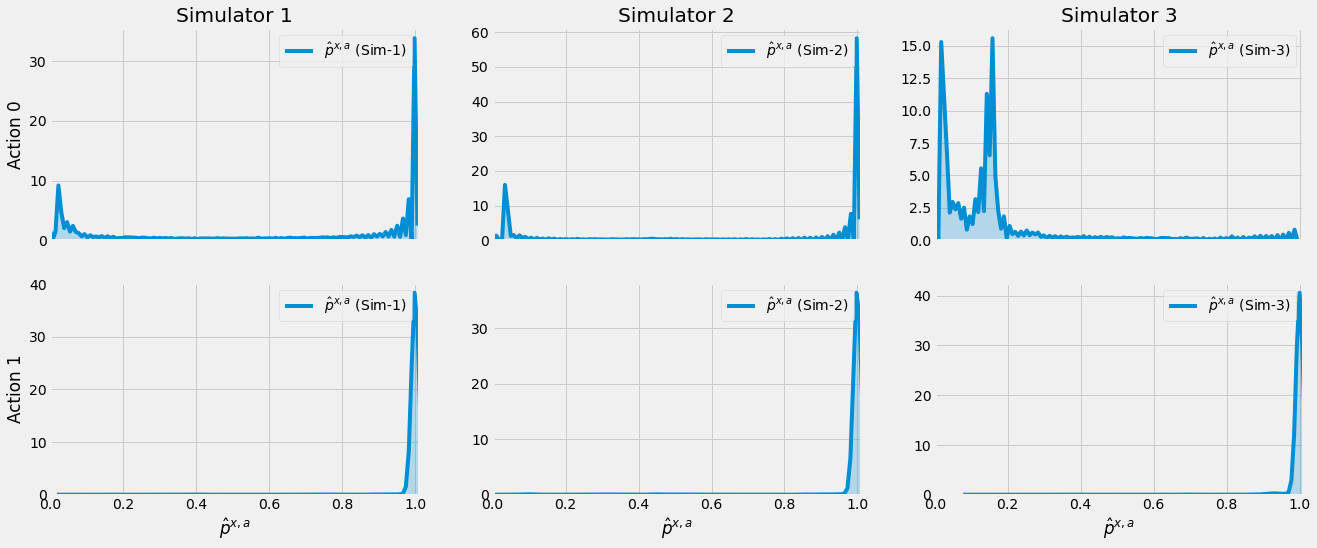

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(20,8), sharex=True)
for a in [0,1]:
    for sim in [1,2,3]:
        if (a == 0):
            sns.kdeplot(data=obs_data_test.loc[obs_data_test['A']==a, "$\hat{{p}}^{{x,a}}$ (Sim-{})".format(sim)], shade=True, bw=0.002, ax=axs[a][sim-1])
        else:
            sns.kdeplot(data=obs_data_test.loc[obs_data_test['A']==a, "$\hat{{p}}^{{x,a}}$ (Sim-{})".format(sim)], shade=True, bw=0.01, ax=axs[a][sim-1])
axs[0][0].set_title('Simulator 1')
axs[0][1].set_title('Simulator 2')
axs[0][2].set_title('Simulator 3')
axs[0][0].set_ylabel('Action 0')
axs[1][0].set_ylabel('Action 1')
axs[1][0].set_xlabel('$\hat{{p}}^{{x,a}}$')
axs[1][1].set_xlabel('$\hat{{p}}^{{x,a}}$')
axs[1][2].set_xlabel('$\hat{{p}}^{{x,a}}$')
plt.style.use('fivethirtyeight')
plt.xlim([0,1.01])


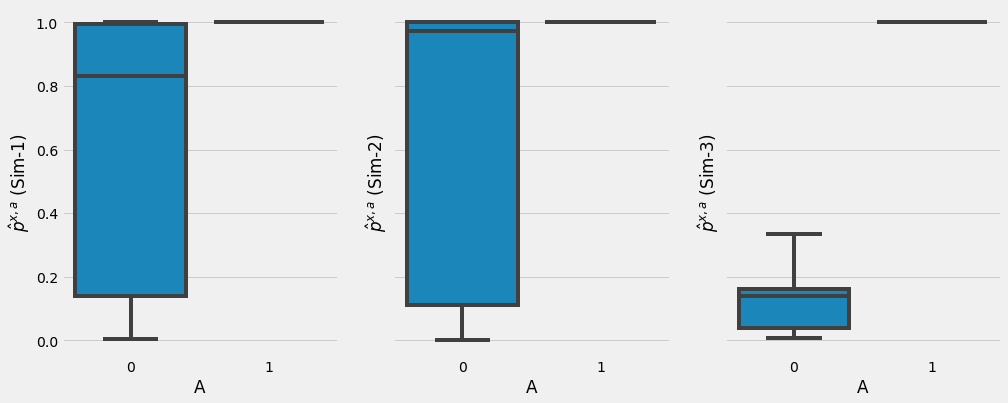

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
plt.style.use('fivethirtyeight')
sns.boxplot(y='$\hat{p}^{x,a}$ (Sim-1)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[0], showfliers=False)
sns.boxplot(y='$\hat{p}^{x,a}$ (Sim-2)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[1], showfliers=False)
sns.boxplot(y='$\hat{p}^{x,a}$ (Sim-3)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[2], showfliers=False)

[Text(0.5, 1.0, 'Simulator 3')]

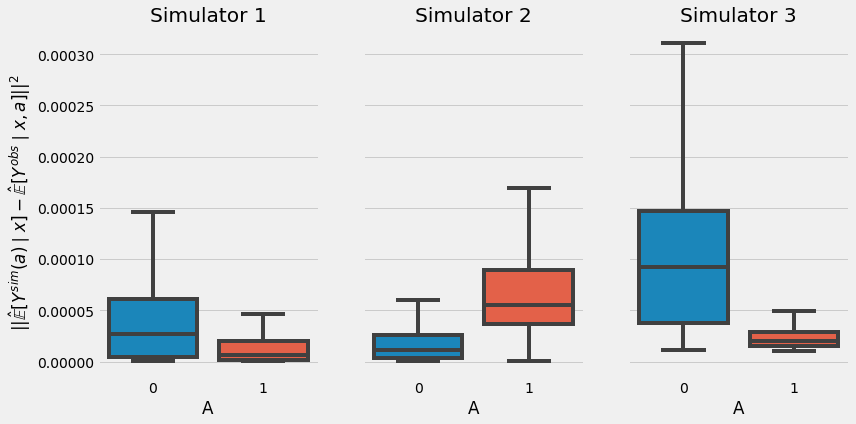

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), sharey=True)
plt.style.use('fivethirtyeight')
sns.boxplot(y='$||Y^{sim} - Y^{obs}||^2$ (Sim-1)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[0], showfliers=False)
axs[0].set(ylabel='$||\hat{\mathbb{E}}[Y^{sim}(a) \mid x] - \hat{\mathbb{E}}[Y^{obs} \mid x, a]||^2$')
axs[0].set(title='Simulator 1')
sns.boxplot(y='$||Y^{sim} - Y^{obs}||^2$ (Sim-2)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[1], showfliers=False)
axs[1].set(ylabel=None)
axs[1].set(title='Simulator 2')
sns.boxplot(y='$||Y^{sim} - Y^{obs}||^2$ (Sim-3)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[2], showfliers=False)
axs[2].set(ylabel=None)
axs[2].set(title='Simulator 3')

# Plotting bounds on the simulator

In [78]:
screen = env.render(mode='rgb_array').transpose((2, 0, 1))
np.save("/data/localhost/taufiq/export-dir/cartpole_env", screen)

In [87]:
screen = np.load("/data/localhost/taufiq/export-dir/cartpole_env.npy")
screen2 = np.load("/data/localhost/taufiq/export-dir/cartpole_env_<-1.5.npy")

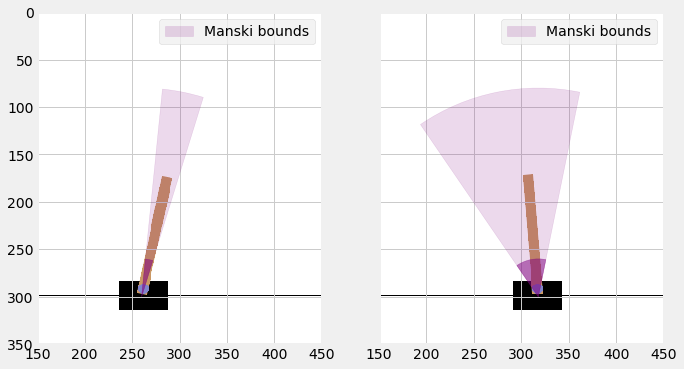

In [98]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

def filled_arc(center, radius, theta1, theta2, ax, color):

    circ = mpatches.Wedge(center, radius, theta1*180/np.pi, theta2*180/np.pi, fill=True, color=color, alpha=0.15)
    circ2 = mpatches.Wedge(center, 40, theta1*180/np.pi, theta2*180/np.pi, fill=True, color=color, alpha=0.5)
    pt1 = (radius * (np.cos(theta1)) + center[0],
           radius * (np.sin(theta1)) + center[1])
    pt2 = (radius * (np.cos(theta2)) + center[0],
           radius * (np.sin(theta2)) + center[1])
    pt3 = center
    pol = mpatches.Polygon([pt1, pt2, pt3], lw=2)
    ax.add_patch(circ)
    ax.add_patch(circ2)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,10))
ax[0].imshow(get_screen(screen).cpu().permute(1, 2, 0).numpy(), interpolation='none')
ax[1].imshow(get_screen(screen2).cpu().permute(1, 2, 0).numpy(), interpolation='none')
filled_arc((260,300), 220, 3*np.pi/2 + 0.10, 3*np.pi/2 + 0.30, ax[0], "purple")
plt.style.use('fivethirtyeight')
ax[0].legend(['Manski bounds'])
ax[0].set_xlim([150, 450])
ax[0].set_ylim([350, 0])
# ax[0].set_title('Action 0')
filled_arc((318,300), 220, 3*np.pi/2 - 0.6, 3*np.pi/2 + 0.2, ax[1], "purple")
ax[1].set_xlim([150, 450])
ax[1].set_ylim([350, 0])
ax[1].legend(['Manski bounds'])
# ax[1].set_title('Action 1')


# Simulators with different perturbations

In [13]:
nreps = 100
outcome = 'Pole Angle'
obs_data_train = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid-train.csv")
obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid-test.csv")

sim_data = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-sim-data-iid.csv")
df = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid.csv")
df_partial = df.copy()
df2 = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data.csv")
sim2 = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-sim-data-rand-policy.csv")
x_columns = ['Pole Angular Velocity', 'Pole Angle']

In [13]:
softmax = torch.nn.Softmax(dim=1)
a_ = torch.tensor(obs_data_train['A'].values).long()
pol_val = softmax(policy(torch.FloatTensor(obs_data_raw[x_columns].values)))[torch.arange(len(obs_data_train)),a_].detach().numpy()

(pol_val > 0.8).mean()


In [1424]:
pol_val[obs_data_train['Pole Angular Velocity']<-1.0].mean()

0.81982255

In [1471]:
(obs_data_train['Pole Angular Velocity']>0.2).mean()

0.220075

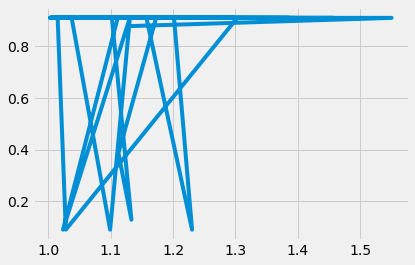

In [1418]:
plt.plot(obs_data_train.loc[obs_data_train['Pole Angular Velocity']>1.0,'Pole Angular Velocity'], pol_val[obs_data_train['Pole Angular Velocity']>1.0])


In [1274]:
(pol_val>0.8).mean()

0.5685

In [1434]:
models_dir="/data/localhost/not-backed-up/taufiq/Cartpole/cartpole-models/"
# sim_data2 = obs_data_train[pol_val>0].copy()
sim_data2 = obs_data_train.copy()

# sim_data2[f'{outcome}_t1'] += 0.01*(pol_val>0.90)*np.random.normal(size=len(sim_data2))

# sim_data2[f'{outcome}_t1'] -= (sim_data2['Pole Angular Velocity']>0)*0.01
# sim_data2[f'{outcome}_t1'] += (sim_data2['Pole Angular Velocity']<0)*0.01

# sim_data2[f'{outcome}_t1'] += (pol_val>0.90)*0.001
# sim_data2[f'{outcome}_t1'] += (pol_val>0.75)*0.005*np.random.normal(size=len(sim_data2))
# sim_data2[f'{outcome}_t1'] += (pol_val>0.90)*0.001

sim_data2_raw = (sim_data2[x_columns] - df[x_columns].mean())/df[x_columns].std()
# sim_data2['A'] = 1 - sim_data2['A']

# a_ = torch.tensor(obs_data_train['A'].values).long()
# pol_val = softmax(policy(torch.FloatTensor(obs_data_raw[x_columns].values)))[torch.arange(len(obs_data_train)),a_].detach().numpy()

# i=0
# ymin_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
# ymin_net.load_state_dict(torch.load(f'{models_dir}/ymin_0.999_{i}'))
# ymin_net.eval()

X = torch.FloatTensor(sim_data2_raw.values)
A = torch.FloatTensor(sim_data2['A'].values)
sim_data2[f'{outcome}_t1'] = obs_net(torch.column_stack((X, A))).reshape(-1).detach().numpy()*df[outcome].std() + df[outcome].mean() + (obs_data_train['Pole Angular Velocity'].abs()>0.80)*0.5*np.random.normal(size=len(sim_data2))**2

# sim_data2[f'{outcome}_t1'] = (ymin_net(torch.column_stack((X, A))).reshape(-1).detach().numpy()*df[outcome].std() + df[outcome].mean() -0.1)
# sim_data2[f'{outcome}_t1'] -= (0.0001)*(sim_data2[f'{outcome}_t1']<0)
# sim_data2[f'{outcome}_t1'] += (0.0001)*(sim_data2[f'{outcome}_t1']>0)

# sim_data2 = sim_data2.append(obs_data_train, ignore_index=True)
# sim_data2_raw = (sim_data2[x_columns] - df[x_columns].mean())/df[x_columns].std()



In [1435]:
sim_data2.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t,Cart Position_t1,Pole Angle_t1
0,0.0,-1.503808,-0.041470,-0.010852,0.044066,0.0,348.0,-1.504637,-0.010070
1,1.0,-1.306983,-0.142117,0.009000,0.037744,1.0,291.0,-1.309825,0.009997
2,0.0,-1.275438,-0.041923,0.002854,-0.068585,2.0,244.0,-1.276276,0.001590
3,1.0,0.046197,0.003991,0.018548,0.018137,3.0,0.0,0.046277,0.019587
4,0.0,-1.572636,0.175385,0.015564,-0.288867,4.0,399.0,-1.569128,0.009725


In [9]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net2(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_hidden2, n_output):
        super(Net2, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden2)   # hidden2 layer
        self.predict = torch.nn.Linear(n_hidden2, n_output)   # output layer
        self.leakyRelu = torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.leakyRelu(self.hidden(x))      # activation function for hidden layer
        x = self.leakyRelu(self.hidden2(x))   
        x = self.predict(x)             # linear output
        return x

In [1437]:
grp = np.floor(5*np.random.rand(len(sim_data2))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(sim_data2_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(sim_data2_raw.loc[testidx].values)
A = torch.FloatTensor(sim_data2.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(sim_data2.loc[testidx, 'A'].values)

Y = torch.FloatTensor((sim_data2.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((sim_data2.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
sim2_net = Net(n_feature=len(sim_data2_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(sim2_net.parameters(), lr=0.001)
losses = []

In [1438]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = sim2_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(sim2_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


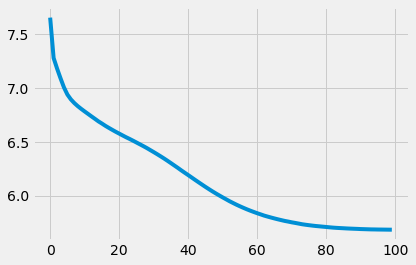

In [1439]:
plt.plot(losses)

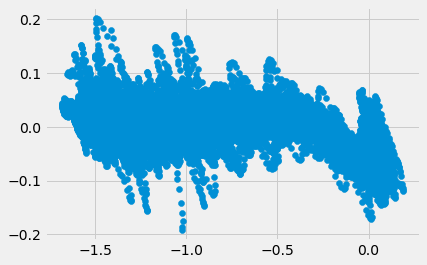

In [1306]:
obs_eps = pd.read_csv("/data/localhost/not-backed-up/taufiq/Cartpole/Cartpole-v1-obs-data-run10-ep100-combined.csv")

plt.scatter(obs_eps['Cart Position'], obs_eps['Pole Angle'])


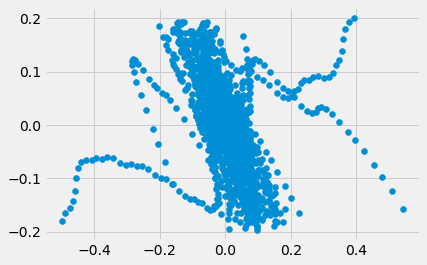

In [307]:
sim_eps = pd.read_csv("/data/localhost/not-backed-up/taufiq/Cartpole/simulator_data/Cartpole-v1-sim-data-run10-ep100-combined.csv")

plt.scatter(sim_eps['Cart Position'], sim_eps['Pole Angle'])


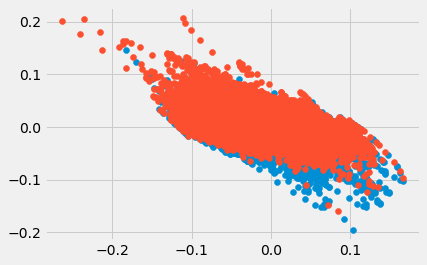

In [615]:
plt.scatter(df2.loc[df2['A']==0,'Cart Position'], df2.loc[df2['A']==0,'Pole Angle'])
plt.scatter(df2.loc[df2['A']==1,'Cart Position'], df2.loc[df2['A']==1,'Pole Angle'])


In [149]:
df['Pole Angle'].std()

0.03162077258613766

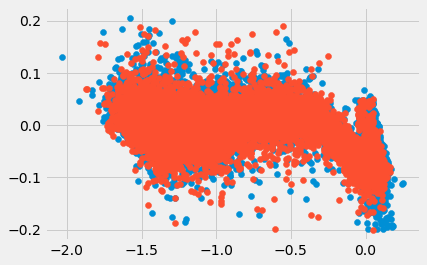

In [618]:
plt.scatter(df.loc[df['Pole Angular Velocity']<0,'Cart Position'], df.loc[df['Pole Angular Velocity']<0,'Pole Angle'])
plt.scatter(df.loc[df['Pole Angular Velocity']>0,'Cart Position'], df.loc[df['Pole Angular Velocity']>0,'Pole Angle'])


0.25551948051948054

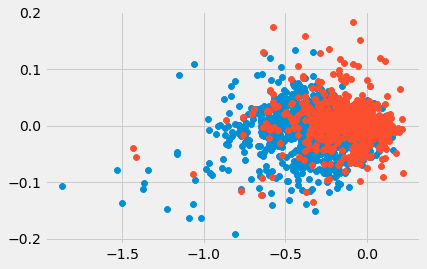

In [1544]:

df1 = df[df['Cart Velocity']>0]
plt.scatter(df1.loc[df1['A']==0, 'Pole Angular Velocity'], df1.loc[df1['A']==0,'Pole Angle'])
plt.scatter(df1.loc[df1['A']==1, 'Pole Angular Velocity'], df1.loc[df1['A']==1,'Pole Angle'])
# df.head()

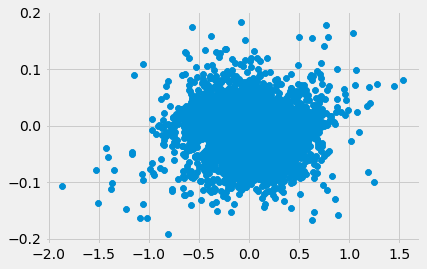

In [1541]:
plt.scatter(df['Pole Angular Velocity'], df['Pole Angle'])


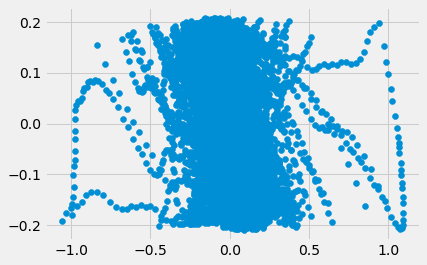

In [305]:
plt.scatter(sim2['Cart Position'], sim2['Pole Angle'])

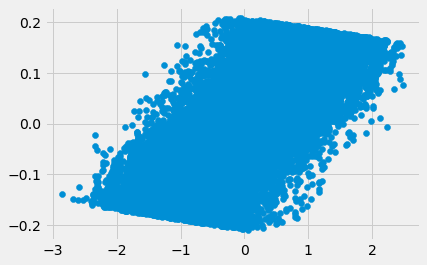

In [678]:
plt.scatter(sim_data['Pole Angular Velocity'], sim_data['Pole Angle'])

In [152]:
sim_data.std()

A                            0.500003
Cart Position                0.069909
Cart Velocity                0.523560
Pole Angle                   0.084009
Pole Angular Velocity        0.799681
episode                  14433.901067
t                            9.189909
Cart Position_t1             0.076649
Pole Angle_t1                0.096200
dtype: float64

In [153]:
df.std()

A                            0.499986
Cart Position                0.473341
Cart Velocity                0.273244
Pole Angle                   0.031346
Pole Angular Velocity        0.266589
episode                  14433.901067
t                          145.008772
Cart Position_t1             0.471361
Pole Angle_t1                0.031572
dtype: float64

In [158]:
def experimental_results(perturbation, policy=None, ymin_net=None, ymax_net=None):
    obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-test.csv")
    models_dir = "/data/localhost/taufiq/cartpole_sim_run2_rand_pol_sim_x_no_velocity/"
    obs_data_test['A'] = obs_data_test['A'].astype({'A': 'int'})
    obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-1)'] = 0
    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-2)'] = 0
    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-3)'] = 0
    obs_data_test['$\hat{p}^{x,a}$ (DT-1)'] = 0
    obs_data_test['$\hat{p}^{x,a}$ (DT-2)'] = 0
    obs_data_test['$\hat{p}^{x,a}$ (DT-3)'] = 0
    sim_data_dir = "/data/localhost/taufiq/cartpole_sim_false_sims_perturbed_same_sign/"
    sim2_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    sim2_net.load_state_dict(torch.load(f'{models_dir}/ysim_false2_0'))
    sim2_net.eval()
    sim3_net = Ncaet(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    sim3_net.load_state_dict(torch.load(f'{sim_data_dir}/ysim_false2_0_{perturbation}'))
    sim3_net.eval()
    sim_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    sim_net.load_state_dict(torch.load(f'{models_dir}/ysim_0'))
    sim_net.eval()

    for i in tqdm(range(nreps)):
        if policy is None:
            policy = PolicyNetwork(input_dim=len(obs_data_test_raw.columns), output_dim=2)
            policy.load_state_dict(torch.load(f'{models_dir}/policy_{i}'))
            policy.eval()
        obs_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
        obs_net.load_state_dict(torch.load(f'{models_dir}/yobs_{i}'))
        obs_net.eval()
        if ymin_net is None:
            ymin_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
            ymin_net.load_state_dict(torch.load(f'{models_dir}/ymin_01_{i}'))
            ymin_net.eval()
        if ymax_net is None:
            ymax_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
            ymax_net.load_state_dict(torch.load(f'{models_dir}/ymax_99_{i}'))
            ymax_net.eval()

        with torch.no_grad():
            X_val = torch.FloatTensor(obs_data_test_raw.values) 
            A_val = torch.FloatTensor(obs_data_test['A'].values)
            pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            sim_pred = sim_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            sim2_pred = sim2_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            sim3_pred = sim3_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
            mse = torch.square(sim_pred - Y)
            mse2 = torch.square(sim2_pred - Y)
            mse3 = torch.square(sim3_pred - Y)
            pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
            ymin = ymin_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            ymax = ymax_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()        
            obs_data_test['pol_val'] = pol_val.numpy()
            obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-1)'] += mse.numpy()
            obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-2)'] += mse2.numpy()
            obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-3)'] += mse3.numpy()
            obs_data_test['LB'] = (pred*pol_val + (1-pol_val)*ymin).numpy()
            obs_data_test['UB'] = (pred*pol_val + (1-pol_val)*ymax).numpy()
            obs_data_test[f'Sim-1_{outcome}_t1'] = sim_pred.numpy()
            obs_data_test['$\hat{p}^{x,a}$ (DT-1)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-1_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-1_{outcome}_t1']).apply(int)
            obs_data_test[f'Sim-2_{outcome}_t1'] = sim2_pred.numpy()
            obs_data_test['$\hat{p}^{x,a}$ (DT-2)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-2_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-2_{outcome}_t1']).apply(int)
            obs_data_test[f'Sim-3_{outcome}_t1'] = sim3_pred.numpy()
            obs_data_test['$\hat{p}^{x,a}$ (DT-3)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-3_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-3_{outcome}_t1']).apply(int)
            obs_data_test['Bound length'] = obs_data_test['UB'] - obs_data_test['LB']

    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-1)'] /= nreps
    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-2)'] /= nreps
    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-3)'] /= nreps
    obs_data_test['$\hat{p}^{x,a}$ (DT-1)'] /= nreps
    obs_data_test['$\hat{p}^{x,a}$ (DT-2)'] /= nreps
    obs_data_test['$\hat{p}^{x,a}$ (DT-3)'] /= nreps
    return obs_data_test

In [259]:
# results = experimental_results(-0.007)
results = experimental_results(-0.007, policy, ymin_net, ymax_net)

100%|██████████| 250/250 [00:10<00:00, 23.83it/s]


In [131]:
quantile=0.975
i=0

obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid-test.csv")
models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/cartpole-models/"
sim_models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/cartpole-models/"
obs_data_test['A'] = obs_data_test['A'].astype({'A': 'int'})
obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()
sim_data_raw = (sim_data[x_columns] - sim_data[x_columns].mean())/sim_data[x_columns].std()

ymin_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
ymin_net.load_state_dict(torch.load(f'{models_dir}/ymin_{quantile}_{i}'))
ymin_net.eval()

ymax_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
ymax_net.load_state_dict(torch.load(f'{models_dir}/ymax_{quantile}_{i}'))
ymax_net.eval()
X_val = torch.FloatTensor(obs_data_test_raw.values) 
A_val = torch.FloatTensor(obs_data_test['A'].values)

ymin = ymin_net(torch.column_stack((X_val, A_val))).reshape(-1)
ymax = ymax_net(torch.column_stack((X_val, A_val))).reshape(-1)
(ymax>ymin).float().mean()

tensor(1.)

In [2416]:
obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid-test.csv")
df_partial = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid.csv")
models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/cartpole-models/"
sim_models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/cartpole-models/"

obs_data_test['A'] = obs_data_test['A'].astype({'A': 'int'})
obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

X_val = torch.FloatTensor(obs_data_raw.values)
A_val = torch.FloatTensor(obs_data_train['A'].values)
pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]


(pol_val>0.6).float().mean()

tensor(0.7544)

In [411]:
def experimental_results_different_quantiles(noise_std, quantile, sim_net=None, obs_net=None, sim2_net=None, policy=None, ymin_net=None, ymax_net=None):
    obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid-test.csv")
    df_partial = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid.csv")
    models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/models-new-x/"
#     models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/models-nobs-10000/"
    quantile_models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/models-new-x/"
#     quantile_models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/models-nobs-10000/"
    sim_models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/models-new-x/"
#     sim_models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/models-nobs-10000/"
    obs_data_test['A'] = obs_data_test['A'].astype({'A': 'int'})
    obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()
    
    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-1)'] = 0
    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-2)'] = 0
    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-3)'] = 0
    obs_data_test['$\hat{p}^{x,a}$ (DT-1)'] = 0
    obs_data_test['$\hat{p}^{x,a}$ (DT-2)'] = 0
    obs_data_test['$\hat{p}^{x,a}$ (DT-3)'] = 0
    if sim_net is None:
        sim_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=6, n_output=1)
        sim_net.load_state_dict(torch.load(f'{sim_models_dir}/ysim_0'))
        sim_net.eval()

    for i in tqdm(range(nreps)):
        if policy is None or i > 0:
            policy = PolicyNetwork(input_dim=len(obs_data_test_raw.columns), output_dim=2)
            policy.load_state_dict(torch.load(f'{models_dir}/policy_{i}'))
            policy.eval()
        if obs_net is None or i > 0:
            obs_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
            obs_net.load_state_dict(torch.load(f'{models_dir}/yobs_{i}'))
            obs_net.eval()
        if ymin_net is None or i > 0:
            ymin_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
            ymin_net.load_state_dict(torch.load(f'{quantile_models_dir}/ymin_{quantile}_{i}'))
            ymin_net.eval()
            
        ymin_90_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
        ymin_90_net.load_state_dict(torch.load(f'{quantile_models_dir}/ymin_0.9_{i}'))
        ymin_90_net.eval()
        if ymax_net is None or i > 0:
            ymax_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
            ymax_net.load_state_dict(torch.load(f'{quantile_models_dir}/ymax_{quantile}_{i}'))
            ymax_net.eval()

        with torch.no_grad():
            X_val = torch.FloatTensor(obs_data_test_raw.values)
            A_val = torch.FloatTensor(obs_data_test['A'].values)
            pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
            pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
            ymin = ymin_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            ymin = 0.99*ymin + (-0.418)*0.01
            ymax = ymax_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            ymin_90 = ymin_90_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            ymin_90 = 0.995*ymin_90 + (-0.418)*0.005
            ymax = 0.99*ymax + (0.418)*0.01
            lb = (pred*pol_val + (1-pol_val)*ymin)
            lb_90 = (pred*pol_val + (1-pol_val)*ymin_90)
            ub = (pred*pol_val + (1-pol_val)*ymax)
            if i == 0:
                sim_pred = sim_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
                sim_pred = torch.where(pol_val < 1, lb_90, sim_pred)
                sim3_pred = torch.where(pol_val >= 0.90, pred + 0.0005, pred)
                sim2_pred = pred
            mse = torch.square(sim_pred - pred)
            mse2 = torch.square(sim2_pred - pred)
            mse3 = torch.square(sim3_pred - pred)
            obs_data_test['ymin'] = ymin
            obs_data_test['ymax'] = ymax
            obs_data_test['pol_val'] = pol_val.numpy()
            obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-1)'] += mse.numpy()
            obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-2)'] += mse2.numpy()
            obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-3)'] += mse3.numpy()
            obs_data_test['LB'] = lb.numpy()
            obs_data_test['UB'] = ub.numpy()
            obs_data_test[f'Sim-1_{outcome}_t1'] = sim_pred.numpy()
            obs_data_test['$\hat{p}^{x,a}$ (DT-1)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-1_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-1_{outcome}_t1']).apply(int)
            obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
            obs_data_test[f'Sim-2_{outcome}_t1'] = sim2_pred.numpy()
            obs_data_test['$\hat{p}^{x,a}$ (DT-2)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-2_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-2_{outcome}_t1']).apply(int)
            obs_data_test[f'\theta^{{*}} (DT-2) i={i}'] = ((sim2_pred - pred*pol_val)/(1-pol_val)).numpy()
            obs_data_test[f'Sim-3_{outcome}_t1'] = sim3_pred.numpy()
            obs_data_test['$\hat{p}^{x,a}$ (DT-3)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-3_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-3_{outcome}_t1']).apply(int)
            obs_data_test[f'\theta^{{*}} (DT-3) i={i}'] = ((sim3_pred - pred*pol_val)/(1-pol_val)).numpy()
            obs_data_test['Bound length'] = obs_data_test['UB'] - obs_data_test['LB']

    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-1)'] /= nreps
    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-2)'] /= nreps
    obs_data_test['$||Y^{sim} - Y^{obs}||^2$ (DT-3)'] /= nreps
    obs_data_test['$\hat{p}^{x,a}$ (DT-1)'] /= nreps
    obs_data_test['$\hat{p}^{x,a}$ (DT-2)'] /= nreps
    obs_data_test['$\hat{p}^{x,a}$ (DT-3)'] /= nreps
    return obs_data_test

In [12]:
# results = experimental_results(-0.01)
results = experimental_results(-0.007, policy, ymin_net, ymax_net)

(0.0, 1.01)

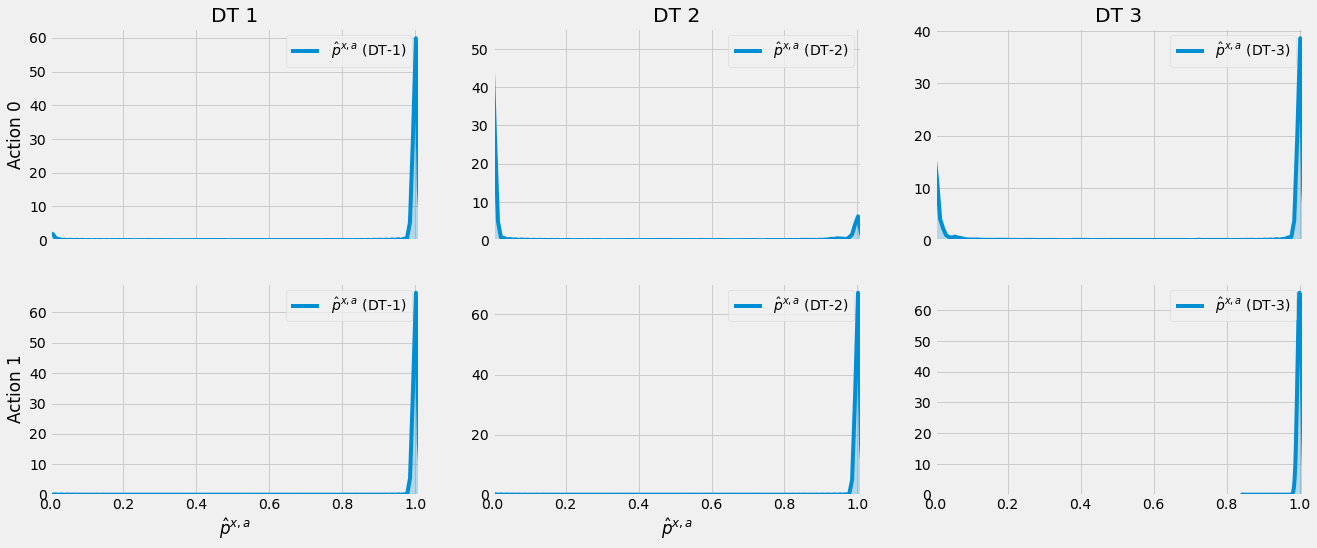

In [23]:
# -0.009
fig, axs = plt.subplots(2, 3, figsize=(20,8), sharex=True)
for a in [0,1]:
    for sim in [1,2,3]:
        if (a == 0):
            sns.kdeplot(data=results.loc[obs_data_test['A']==a, "$\hat{{p}}^{{x,a}}$ (DT-{})".format(sim)], shade=True, bw=0.006, ax=axs[a][sim-1])
        else:
            sns.kdeplot(data=results.loc[obs_data_test['A']==a, "$\hat{{p}}^{{x,a}}$ (DT-{})".format(sim)], shade=True, bw=0.006, ax=axs[a][sim-1])
axs[0][0].set_title('DT 1')
axs[0][1].set_title('DT 2')
axs[0][2].set_title('DT 3')
axs[0][0].set_ylabel('Action 0')
axs[1][0].set_ylabel('Action 1')
axs[1][0].set_xlabel('$\hat{{p}}^{{x,a}}$')
axs[1][1].set_xlabel('$\hat{{p}}^{{x,a}}$')
plt.style.use('fivethirtyeight')
plt.xlim([0,1.01])


In [412]:
results = pd.DataFrame()
quantiles = [0.90, 0.95, 0.975, 0.99, 0.999]
# quantiles = [0.90, 0.95]
for quantile in quantiles:
    results_df = experimental_results_different_quantiles(0.001, quantile, sim_net)
    results_df['quantile'] = quantile
    results = pd.concat([results, results_df], axis = 0)
    

 26%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 26/100 [00:01<00:03, 19.04it/s]/tmp/ipykernel_1053574/3580914875.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-3) i={i}'] = ((sim3_pred - pred*pol_val)/(1-pol_val)).numpy()
 28%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                       

 34%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                        | 34/100 [00:01<00:04, 14.86it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 40/100 [00:02<00:04, 13.59it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 46/100 [00:02<00:04, 12.74it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 52/100 [00:03<00:03, 13.88it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 58/100 [00:03<00:03, 13.67it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 64/100 [00:04<00:02, 12.48it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 70/100 [00:04<00:02, 12.78it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 76/100 [00:05<00:01, 13.43it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 82/100 [00:05<00:01, 12.50it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 88/100 [00:06<00:00, 12.04it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 94/100 [00:06<00:00, 12.87it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.29it/s]
/tmp/ipykernel_1053574/3741472665.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df['quantile'] = quantile
 25%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 25/100 [00:01<00:03, 21.70it/s]/tmp/ipyke

 33%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                           | 33/100 [00:01<00:04, 15.30it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 39/100 [00:02<00:04, 14.32it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 45/100 [00:02<00:04, 12.99it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 51/100 [00:03<00:04, 11.88it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 57/100 [00:03<00:03, 12.52it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 63/100 [00:04<00:02, 12.79it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 69/100 [00:04<00:02, 12.16it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 75/100 [00:05<00:02, 11.21it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 81/100 [00:05<00:01, 12.61it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 87/100 [00:06<00:01, 12.23it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 93/100 [00:06<00:00, 12.30it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 99/100 [00:07<00:00, 12.88it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 33%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                           | 33/100 [00:01<00:04, 16.38it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 39/100 [00:02<00:04, 13.12it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 45/100 [00:02<00:04, 12.80it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 51/100 [00:03<00:03, 13.08it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 57/100 [00:03<00:03, 13.19it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 63/100 [00:04<00:02, 13.18it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 69/100 [00:04<00:02, 12.05it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 75/100 [00:05<00:02, 11.63it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 81/100 [00:05<00:01, 12.48it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 87/100 [00:06<00:01, 11.90it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 93/100 [00:06<00:00, 12.38it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 99/100 [00:07<00:00, 13.07it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-2) i={i}'] = ((sim2_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-2) i={i}'] = ((sim2_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-2) i={i}'] = ((sim2_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-2) i={i}'] = ((sim2_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-2) i={i}'] = ((sim2_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

/tmp/ipykernel_1053574/3580914875.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-3) i={i}'] = ((sim3_pred - pred*pol_val)/(1-pol_val)).numpy()
 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 63/100 [00:04<00:03, 12.14it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a 

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 69/100 [00:04<00:02, 12.83it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 75/100 [00:05<00:02, 12.21it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 81/100 [00:05<00:01, 11.93it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 87/100 [00:06<00:01, 12.18it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 93/100 [00:06<00:00, 12.71it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 99/100 [00:07<00:00, 12.84it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 32%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                              | 32/100 [00:01<00:04, 16.27it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 38/100 [00:02<00:04, 14.17it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 44/100 [00:02<00:04, 12.41it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 50/100 [00:03<00:04, 12.41it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 56/100 [00:03<00:03, 12.52it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 62/100 [00:04<00:03, 12.31it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 68/100 [00:04<00:02, 12.85it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 74/100 [00:05<00:02, 12.52it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 80/100 [00:05<00:01, 12.61it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 86/100 [00:06<00:01, 12.38it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 92/100 [00:06<00:00, 11.51it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 98/100 [00:07<00:00, 11.02it/s]/tmp/ipykernel_1053574/3580914875.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_data_test[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
/tmp/ipykernel_1053574/3580914875.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

In [413]:
(results['pol_val']>=0.90).mean()

0.1594

In [414]:
results_cls = results.copy()
for sim in [1, 2, 3]:
    results_cls = results_cls.rename(columns={"$\hat{{p}}^{{x,a}}$ (DT-{})".format(sim): "DT {}".format(sim)})
    

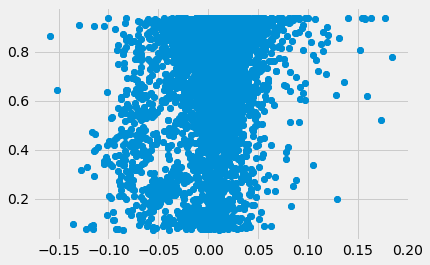

In [415]:
plt.scatter(results_cls.loc[results_cls['A']==1, 'Pole Angle'], results_cls.loc[results_cls['A']==1,'pol_val'])

In [416]:
((results_cls['Pole Angle_t1'] < results_cls['ymin']) | (results_cls['Pole Angle_t1'] > results_cls['ymax'])).mean()


0.0

/data/ziz/taufiq/myenv/lib64/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/data/ziz/taufiq/myenv/lib64/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/data/ziz/taufiq/myenv/lib64/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/data/ziz/taufiq/myenv/lib64/python3.9/site-packages/seaborn/distributions.py:1699

/data/ziz/taufiq/myenv/lib64/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


(0.0, 1.01)

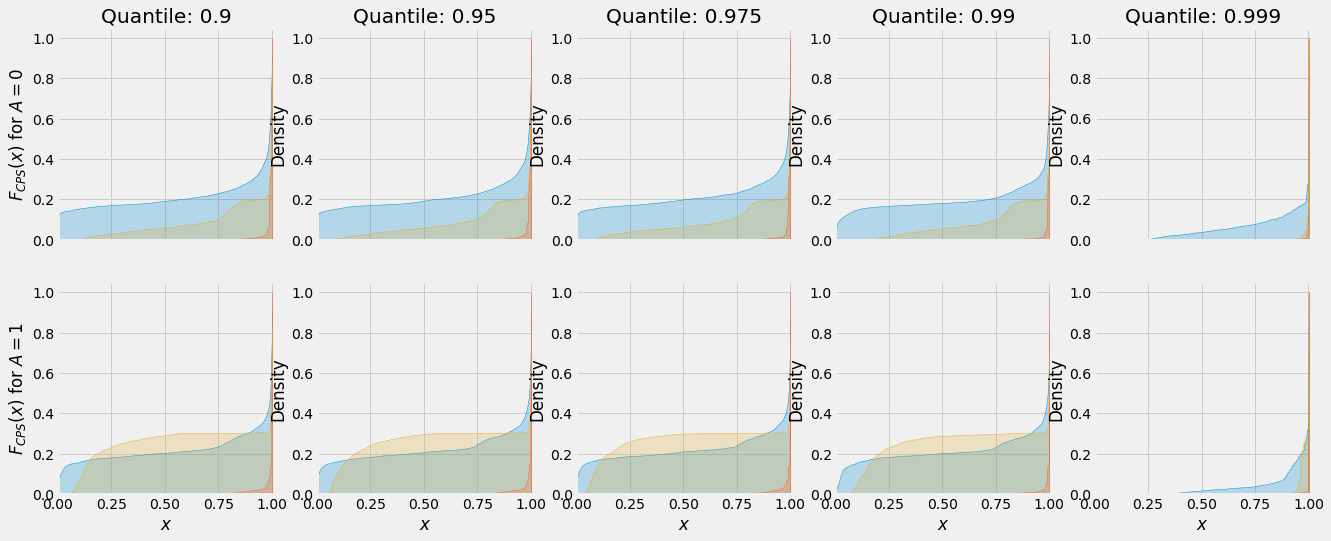

In [314]:
# -0.009

fig, axs = plt.subplots(2, len(quantiles), figsize=(20,8), sharex=True)
for a in [0,1]:
    for sim in [1,2, 3]:
        for i in range(len(quantiles)):
            sns.kdeplot(data=results_cls.loc[(results_cls['A']==a) & (results_cls['quantile']==quantiles[i]), "DT {}".format(sim)], shade=True, cumulative=True, bw=0.01, ax=axs[a][i])
            axs[0][i].set_title(f'Quantile: {quantiles[i]}')
            axs[1][i].set_xlabel('$x$')
axs[0][0].set_ylabel('$F_{CPS}(x)$ for $A=0$')
axs[1][0].set_ylabel('$F_{CPS}(x)$ for $A=1$')
plt.style.use('fivethirtyeight')
plt.xlim([0,1.01])


In [417]:
num_trajecs_a0 = ((results_cls['quantile']==0.95) & (results_cls['A']==0)).sum()
num_trajecs_a1 = ((results_cls['quantile']==0.95) & (results_cls['A']==1)).sum()
results_copy = pd.DataFrame()
for sim in [1,2, 3]:
    df = results_cls.copy()
    df['CPS'] = df[f"DT {sim}"]
    df['x'] = df[f"DT {sim}"].apply(lambda x: "< 0.05" if x < 0.05 else ("> 0.95" if x > 0.95 else "0.05 - 0.95"))
    df['DT'] = f"DT {sim}"
    results_copy = pd.concat([results_copy, df], axis=0)
results_copy['Count'] = results_copy.index
results_copy = results_copy[['DT', 'x', 'A', 'quantile', 'Count']].groupby(by=['DT', 'x', 'quantile', 'A']).count().reset_index()
results_copy['DT-x-quantile-A'] = results_copy[['DT', 'x', 'quantile', 'A']].apply(lambda x: x['DT'] + x['x'] + str(x['quantile']) + str(x['A']), axis=1)
len(results_copy)


67

In [418]:
dts = results_copy['DT'].unique()
xs = results_copy['x'].unique()
qs = results_copy['quantile'].unique()
for d in dts:
    for x in xs:
        for q in qs:
            for a in [0,1]:
                if (d+x+str(q)+str(a)) not in results_copy['DT-x-quantile-A'].unique():
                    results_copy = results_copy.append({'DT': d, 'x': x, 'quantile': q, 'A': a, 'Count': 0, 'DT-x-quantile-A': (d+x+str(q)+str(a))}, ignore_index=True)
                    
len(results_copy)

/tmp/ipykernel_1053574/2594503391.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_copy = results_copy.append({'DT': d, 'x': x, 'quantile': q, 'A': a, 'Count': 0, 'DT-x-quantile-A': (d+x+str(q)+str(a))}, ignore_index=True)
/tmp/ipykernel_1053574/2594503391.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_copy = results_copy.append({'DT': d, 'x': x, 'quantile': q, 'A': a, 'Count': 0, 'DT-x-quantile-A': (d+x+str(q)+str(a))}, ignore_index=True)
/tmp/ipykernel_1053574/2594503391.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_copy = results_copy.append({'DT': d, 'x': x, 'quantile': q, 'A': a, 'Count': 0, 'DT-x-quantile-A': (d+x+str(q)+str(a))}, ignore_index=True)
/tmp/ipykernel_1053574/25945033

90

In [419]:
results_ordered = pd.concat([results_copy.loc[results_copy['x']=="< 0.05"], results_copy.loc[results_copy['x']=="0.05 - 0.95"], results_copy.loc[results_copy['x']=="> 0.95"]])
results_ordered['%-age'] = results_ordered['Count']/num_trajecs_a0*100
results_ordered.loc[results_ordered['A']==1, '%-age'] = results_ordered['Count']/num_trajecs_a1*100


In [2469]:
# results_ordered = pd.read_csv("/data/localhost/taufiq/cartpole_sim_run3_multiple_quantiles/results_multiple_quantiles.csv")
results_cls.to_csv("/data/localhost/taufiq/cartpole_sim_run3_multiple_quantiles/results_for_heatmap.csv", index=False)

In [218]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap




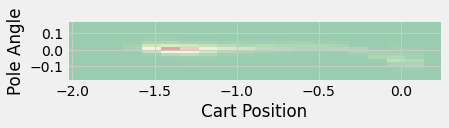

In [552]:
cmap = plt.get_cmap('RdYlGn_r')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)
x = results_cls['Cart Position']
y = results_cls['Pole Angle']
heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=new_cmap, alpha=0.4)
plt.xlabel("Cart Position")
plt.ylabel("Pole Angle")
plt.show()


/tmp/ipykernel_269610/2533443222.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.05, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))


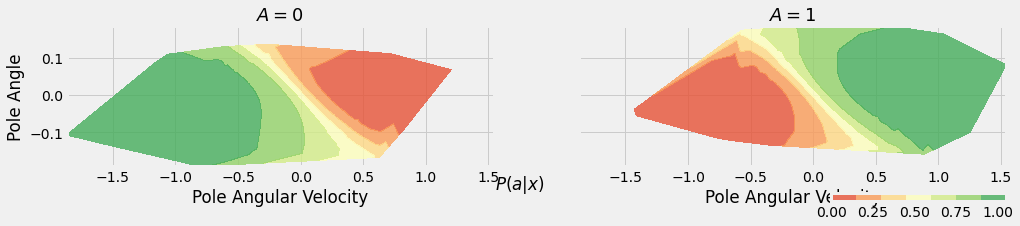

In [188]:
import matplotlib.tri as tri

fig, axs = plt.subplots(1, 2, figsize=(15,3), sharex=True, sharey=True)
cmap = plt.get_cmap('RdYlGn')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)
for action in range(2):
    results_filtered = results_cls[(results_cls['A']==action)]
    x = results_filtered[x_columns[0]]
    y = results_filtered[x_columns[1]]
    z = results_filtered[f'pol_val'].apply(lambda x: min(x, 0.999))
    vals = axs[action].tricontourf(x, y, z, cmap=new_cmap, alpha=0.8)
    axs[action].set_title(f"$A={action}$", fontsize=18)
    axs[action].set_xlabel(x_columns[0])
        
axs[0].set_ylabel(x_columns[1])

cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.05, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))
cbar.set_ticks(np.arange(5)/4)
st = fig.suptitle(f"$P(a|x)$")
st.set_y(0.20)
# cbar.set_label("")
plt.show()

/tmp/ipykernel_269610/2975552451.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.5, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))


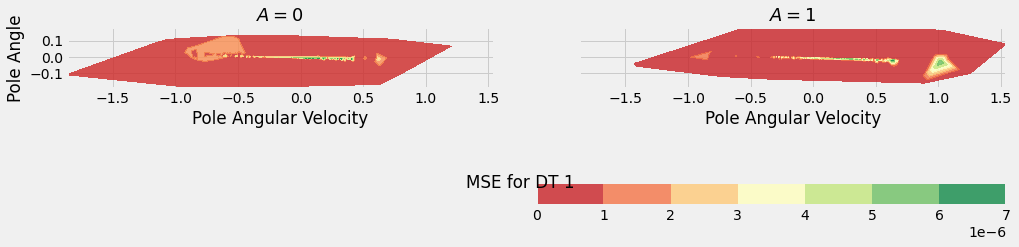

In [29]:
action = 1
DT = 1
# quantiles = [0.90, 0.95]
fig, axs = plt.subplots(1, 2, figsize=(15,3), sharex=True, sharey=True)
cmap = plt.get_cmap('RdYlGn')
# new_cmap = truncate_colormap(cmap, 0.1, 0.9)
for i in range(2):
    results_filtered = results_cls[(results_cls['A']==i)]
    x = results_filtered[x_columns[0]]
    y = results_filtered[x_columns[1]]
    z = results_filtered[f'$||Y^{{sim}} - Y^{{obs}}||^2$ (DT-{DT})']
    vals = axs[i].tricontourf(x, y, z, cmap=cmap, alpha=0.8)
    axs[i].set_title(f"$A={i}$", fontsize=18)
    axs[i].set_xlabel(x_columns[0])
        
# plt.grid(False)
axs[0].set_ylabel(x_columns[1])
# plt.clim(0, 1)?

cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.5, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))
# cbar.set_ticks(np.arange(5)/4)
st = fig.suptitle(f"MSE for DT {DT}")
st.set_y(0.20)
# cbar.set_label("CPS")
plt.show()

In [30]:
results_cls

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t,Cart Position_t1,Pole Angle_t1,$||Y^{sim} - Y^{obs}||^2$ (DT-1),...,ymin,ymax,pol_val,LB,UB,Sim-1_Pole Angle_t1,Sim-2_Pole Angle_t1,Sim-3_Pole Angle_t1,Bound length,quantile
0,1,-1.328107,-0.552916,0.025783,0.563745,9.0,223.0,-1.339165,0.037058,5.131907e-09,...,0.031848,0.040801,0.937596,0.036732,0.037291,0.037130,0.032057,0.036732,0.000559,0.900
1,1,-1.503026,-0.140571,-0.001680,0.102165,11.0,387.0,-1.505837,0.000364,4.036012e-09,...,-0.004477,0.004496,0.711089,-0.001035,0.001558,0.000427,0.000464,-0.001035,0.002592,0.900
2,1,-1.296141,-0.147858,-0.031576,0.218185,15.0,463.0,-1.299098,-0.027213,1.208124e-07,...,-0.031943,-0.022808,0.752128,-0.028381,-0.026117,-0.026865,-0.027107,-0.028381,0.002264,0.900
3,1,-0.718634,-0.601867,0.007465,0.259945,17.0,103.0,-0.730671,0.012664,4.459260e-09,...,0.007702,0.016660,0.894635,0.012141,0.013085,0.012730,0.007663,0.012141,0.000944,0.900
4,1,-0.482321,-0.602832,-0.004788,0.289486,19.0,97.0,-0.494377,0.001002,8.988943e-09,...,-0.003908,0.005125,0.893622,0.000479,0.001440,0.001096,-0.003998,0.000479,0.000961,0.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,-1.527100,-0.211357,0.001888,0.168100,49958.0,423.0,-1.531327,0.005250,4.275002e-09,...,-0.015341,0.035408,0.822802,0.001602,0.010594,0.005316,0.005351,0.001602,0.008992,0.999
9996,1,-1.367233,0.036268,-0.010585,-0.025786,49971.0,340.0,-1.366508,-0.011101,1.033417e-06,...,-0.028525,0.020787,0.360533,-0.022243,0.009291,-0.012117,-0.011000,-0.022243,0.031534,0.999
9997,0,0.058185,-0.031586,-0.075140,-0.144613,49973.0,28.0,0.057553,-0.078032,1.384903e-08,...,-0.084186,0.034493,0.848940,-0.078970,-0.061042,-0.078150,-0.077941,-0.078970,0.017928,0.999
9998,0,-0.378724,-0.495700,0.034195,-0.081246,49974.0,61.0,-0.388638,0.032570,3.069910e-08,...,-0.008146,0.058551,0.478878,0.011352,0.046109,0.032745,0.032670,0.011352,0.034757,0.999


/tmp/ipykernel_269610/1071618606.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc)


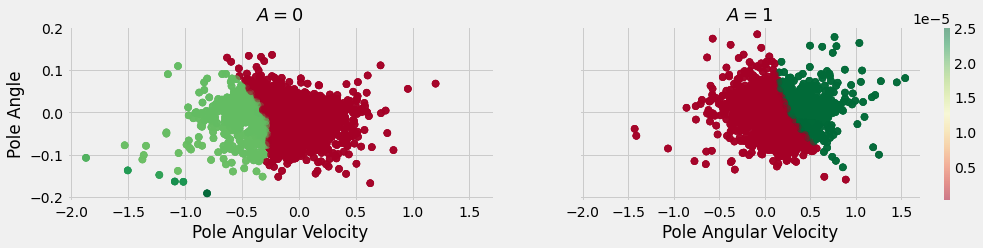

In [142]:
action = 1
DT = 2
# quantiles = [0.90, 0.95]
fig, axs = plt.subplots(1, 2, figsize=(15,3), sharex=True, sharey=True)
cmap = plt.get_cmap('RdYlGn')
new_cmap = truncate_colormap(cmap, 0.01, 0.99)
for i in range(2):
    results_filtered = results_cls[(results_cls['A']==i)]
    x = results_filtered[x_columns[0]]
    y = results_filtered[x_columns[1]]
    z = results_filtered[f'$||Y^{{sim}} - Y^{{obs}}||^2$ (DT-{DT})']
#     vals = axs[i].tricontourf(x, y, z, cmap=cmap, alpha=0.8)
    sc = axs[i].scatter(x=x, y=y, c=z, cmap=cmap, alpha=0.5, s=50)
    axs[i].set_title(f"$A={i}$", fontsize=18)
    axs[i].set_xlabel(x_columns[0])
        
# plt.grid(False)
axs[0].set_ylabel(x_columns[1])
# plt.clim(0, 1)
plt.colorbar(sc)
# cbar = plt.colorbar(cmap=new_cmap, ax=axs, shrink=0.5, fraction=0.1, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))
# cbar.set_ticks(np.arange(5)/4)
# st = fig.suptitle(f"MSE for DT {DT}")
# st.set_y(0.20)
# cbar.set_label("CPS")
plt.show()

/tmp/ipykernel_1053574/3475414251.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(vals)


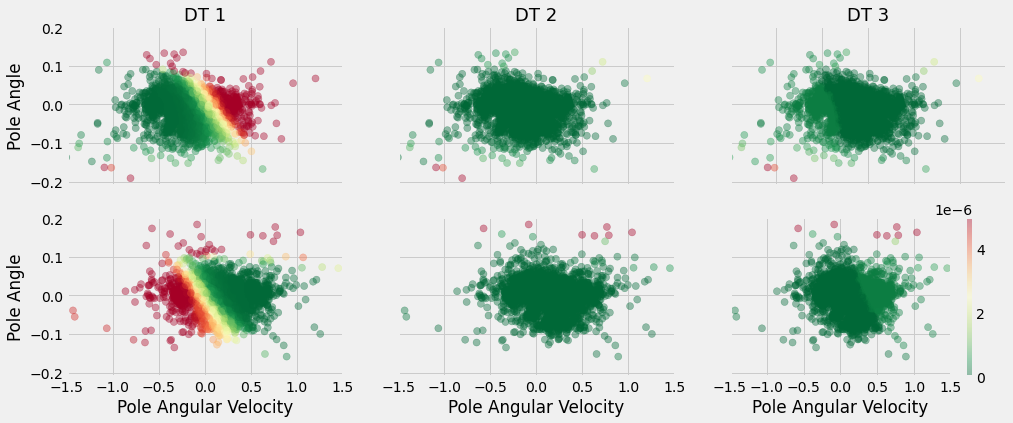

In [426]:
import matplotlib.tri as tri
action = 1
DT = 2
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)
cmap = plt.get_cmap('RdYlGn_r')
new_cmap = cmap
new_cmap = truncate_colormap(cmap, 0, 1)
quantile = 0.999
for i in range(1,4):
    for j in range(2):
        results_filtered = results_cls[(results_cls['quantile']==quantile) & (results_cls['A']==j)]
#         axs[j][i-1].set_aspect('equal')
        x = results_filtered[x_columns[0]]
        y = results_filtered[x_columns[1]]
        z = results_filtered[f'$||Y^{{sim}} - Y^{{obs}}||^2$ (DT-{i})']
        vals = axs[j][i-1].scatter(x=x, y=y, c=z, cmap=new_cmap, vmin=0, vmax=0.5*1e-5, alpha=0.4, s=50)
        axs[j][i-1].set_xlim([-1.5, 1.5])
        if j == 0:
            axs[j][i-1].set_title(f"DT {i}", fontsize=18)
        else:
            axs[j][i-1].set_xlabel(x_columns[0])
        
# plt.grid(False)
axs[0][0].set_ylabel(x_columns[1])
axs[1][0].set_ylabel(x_columns[1])
# plt.clim(0, 1)


plt.colorbar(vals)
# cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.05, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))
# cbar.set_ticks(np.arange(5)/4)
# st = fig.suptitle(f"CPS for DT {DT} ($A={action}$)")

# st.set_y(0.20)
# cbar.set_label("CPS")
plt.show()

In [422]:
results_filtered[f'$||Y^{{sim}} - Y^{{obs}}||^2$ (DT-1)'].max()

0.0006454148872580845

/tmp/ipykernel_1053574/2553749520.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(vals)


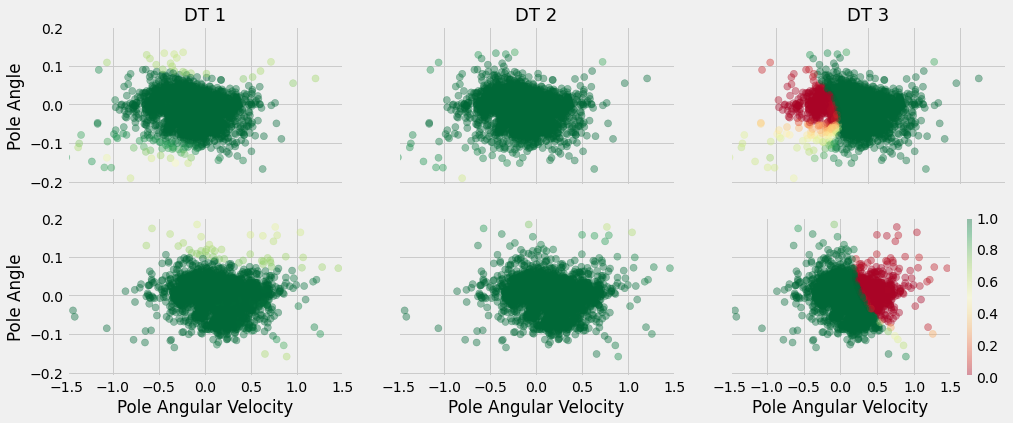

In [421]:
import matplotlib.tri as tri
action = 1
DT = 2
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)
cmap = plt.get_cmap('RdYlGn')
new_cmap = truncate_colormap(cmap, 0.01, 0.999)
quantile = 0.95
for i in range(1,4):
    for j in range(2):
        results_filtered = results_cls[(results_cls['quantile']==quantile) & (results_cls['A']==j)]
#         axs[j][i-1].set_aspect('equal')
        x = results_filtered[x_columns[0]]
        y = results_filtered[x_columns[1]]
        z = results_filtered[f'DT {i}'].apply(lambda x: min(x, 0.999))
        vals = axs[j][i-1].scatter(x=x, y=y, c=z, cmap=new_cmap, vmin=0, vmax=1, alpha=0.4, s=50)
        axs[j][i-1].set_xlim([-1.5, 1.5])
        if j == 0:
            axs[j][i-1].set_title(f"DT {i}", fontsize=18)
        else:
            axs[j][i-1].set_xlabel(x_columns[0])
        
# plt.grid(False)
axs[0][0].set_ylabel(x_columns[1])
axs[1][0].set_ylabel(x_columns[1])
# plt.clim(0, 1)


plt.colorbar(vals)
# cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.05, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))
cbar.set_ticks(np.arange(5)/4)
# st = fig.suptitle(f"CPS for DT {DT} ($A={action}$)")

st.set_y(0.20)
# cbar.set_label("CPS")
plt.show()

/tmp/ipykernel_269610/122669439.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.05, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))


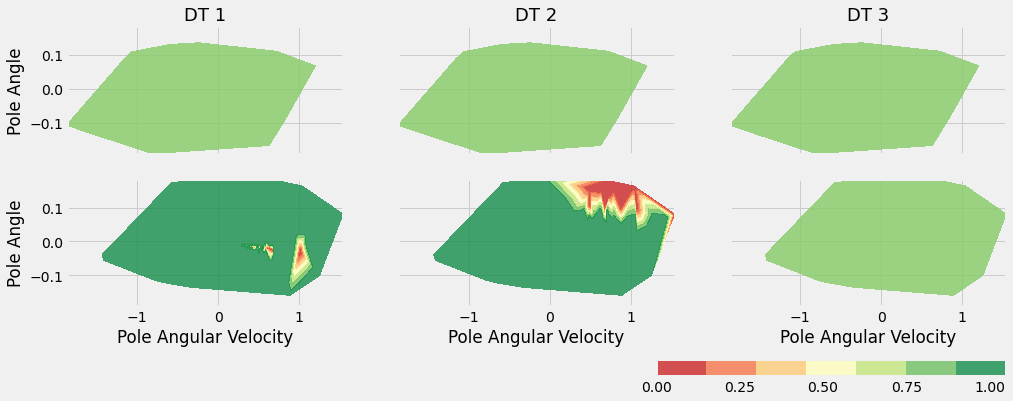

In [557]:
import matplotlib.tri as tri
action = 1
DT = 2
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)
cmap = plt.get_cmap('RdYlGn')
new_cmap = truncate_colormap(cmap, 0.01, 0.99)
quantile = 0.999
for i in range(1,4):
    for j in range(2):
        results_filtered = results_cls[(results_cls['quantile']==quantile) & (results_cls['A']==j)]
#         axs[j][i-1].set_aspect('equal')
        x = results_filtered[x_columns[0]]
        y = results_filtered[x_columns[1]]
        z = results_filtered[f'DT {i}'].apply(lambda x: min(x, 0.999))
        if i == 2:
            vals = axs[j][i-1].tricontourf(x, y, z, cmap=new_cmap, alpha=0.8)
        else:
            axs[j][i-1].tricontourf(x, y, z, cmap=new_cmap, alpha=0.8)
        if j == 0:
            axs[j][i-1].set_title(f"DT {i}", fontsize=18)
        else:
            axs[j][i-1].set_xlabel(x_columns[0])
        
# plt.grid(False)
axs[0][0].set_ylabel(x_columns[1])
axs[1][0].set_ylabel(x_columns[1])
# plt.clim(0, 1)

cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.05, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))
cbar.set_ticks(np.arange(5)/4)
# st = fig.suptitle(f"CPS for DT {DT} ($A={action}$)")
st.set_y(0.20)
# cbar.set_label("CPS")
plt.show()

/tmp/ipykernel_269610/2103987659.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.05, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))


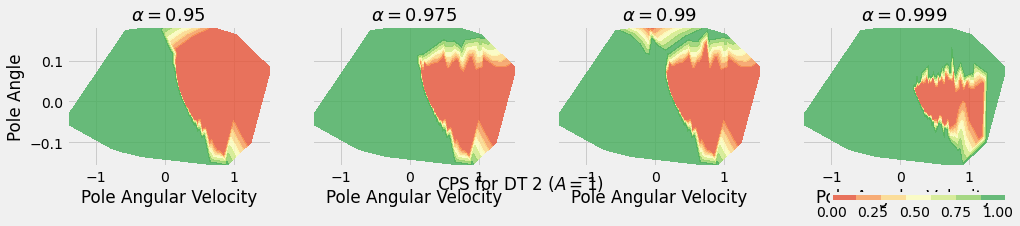

In [44]:
import matplotlib.tri as tri
action = 1
DT = 2
# quantiles = [0.90, 0.95]
fig, axs = plt.subplots(1, len(quantiles), figsize=(15,3), sharex=True, sharey=True)
cmap = plt.get_cmap('RdYlGn')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)
for i in range(len(quantiles)):
    results_filtered = results_cls[(results_cls['quantile']==quantiles[i]) & (results_cls['A']==action)]
#     axs[i].set_aspect('equal')
    x = results_filtered[x_columns[0]]
    y = results_filtered[x_columns[1]]
    z = results_filtered[f'DT {DT}'].apply(lambda x: min(x, 0.999))
#         sigmoid = torch.nn.Sigmoid()
#         z = sigmoid(torch.FloatTensor(results_filtered[f'DT-{j}'])).numpy()
    vals = axs[i].tricontourf(x, y, z, cmap=new_cmap, alpha=0.8)
#     axs[i].scatter(x, y)
#     axs[i].imshow(heatmap.T, extent=extent, origin='lower', alpha=0.2)
    axs[i].set_title(f"$\\alpha={quantiles[i]}$", fontsize=18)
    axs[i].set_xlabel(x_columns[0])
        
# plt.grid(False)
axs[0].set_ylabel(x_columns[1])
# plt.clim(0, 1)

cbar = plt.colorbar(vals, ax=axs, shrink=0.5, fraction=0.05, orientation='horizontal', anchor=(1.0,-0.05), panchor=(0.95,-0.05))
cbar.set_ticks(np.arange(5)/4)
st = fig.suptitle(f"CPS for DT {DT} ($A={action}$)")
st.set_y(0.20)
# cbar.set_label("CPS")
plt.show()


In [33]:
results_cls.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t,Cart Position_t1,Pole Angle_t1,$||Y^{sim} - Y^{obs}||^2$ (DT-1),...,ymin,ymax,pol_val,LB,UB,Sim-1_Pole Angle_t1,Sim-2_Pole Angle_t1,Sim-3_Pole Angle_t1,Bound length,quantile
0,1,-1.328107,-0.552916,0.025783,0.563745,9.0,223.0,-1.339165,0.037058,5.131907e-09,...,0.031848,0.040801,0.937596,0.036732,0.037291,0.037130,0.032057,0.036732,0.000559,0.9
1,1,-1.503026,-0.140571,-0.001680,0.102165,11.0,387.0,-1.505837,0.000364,4.036012e-09,...,-0.004477,0.004496,0.711089,-0.001035,0.001558,0.000427,0.000464,-0.001035,0.002592,0.9
2,1,-1.296141,-0.147858,-0.031576,0.218185,15.0,463.0,-1.299098,-0.027213,1.208124e-07,...,-0.031943,-0.022808,0.752128,-0.028381,-0.026117,-0.026865,-0.027107,-0.028381,0.002264,0.9
3,1,-0.718634,-0.601867,0.007465,0.259945,17.0,103.0,-0.730671,0.012664,4.459260e-09,...,0.007702,0.016660,0.894635,0.012141,0.013085,0.012730,0.007663,0.012141,0.000944,0.9
4,1,-0.482321,-0.602832,-0.004788,0.289486,19.0,97.0,-0.494377,0.001002,8.988943e-09,...,-0.003908,0.005125,0.893622,0.000479,0.001440,0.001096,-0.003998,0.000479,0.000961,0.9


In [34]:
# quantile = 0.999
# action = 0
# plt.figure(figsize=(6,4))
# plt.style.use('fivethirtyeight')
# sns.barplot(data=results_ordered.loc[(results_ordered['A']==action) & (results_ordered['quantile']==quantile)], x="x", hue="DT", y='%-age', alpha=0.75, palette=sns.color_palette("GnBu", 3))
# if action == 1:
#     plt.xlabel("$CPS(x,a)$")
# else:
#     plt.xlabel("")
# if quantile == 0.95:
#     plt.ylabel(f"Action={action}")
# else:
#     plt.ylabel("")
# if action==0:
#     plt.title(f"Quantile: {quantile}")
# if quantile > 0.95:
#     plt.yticks()
# plt.ylim([0,100])

In [47]:
import matplotlib.patches as mpatches

def plot_stacked_bars(axis, quantile, action, results_ordered):
    plt.style.use('fivethirtyeight')
    data_ = results_ordered.loc[(results_ordered['A']==action) & (results_ordered['quantile']==quantile)].copy()
    data_.sort_values(by="DT", inplace=True)
    sns.barplot(ax=axis, data=data_, x="DT", y='%-age', estimator=sum, ci=None, alpha=0.85, color=sns.color_palette("Spectral", 10)[7])
    sns.barplot(ax=axis, data=data_[data_["x"] != "> 0.95"], x="DT", y='%-age', estimator=sum, ci=None, alpha=0.85, color=sns.color_palette("Spectral", 10)[3])
    sns.barplot(ax=axis, data=data_[data_["x"] == "< 0.05"], x="DT", y='%-age', estimator=sum, ci=None, alpha=0.85, color=sns.color_palette("Spectral", 10)[1])
    if action == 1:
        axis.set_xlabel("DT models")
    else:
        axis.set_xlabel("")
    if quantile == 0.95:
        axis.set_ylabel(f"Action={action}")
    else:
        axis.set_ylabel("")
    if action==0:
        axis.set_title(f"$\\alpha={quantile}$")
    if quantile > 0.95:
        plt.yticks()
    plt.ylim([0,100])

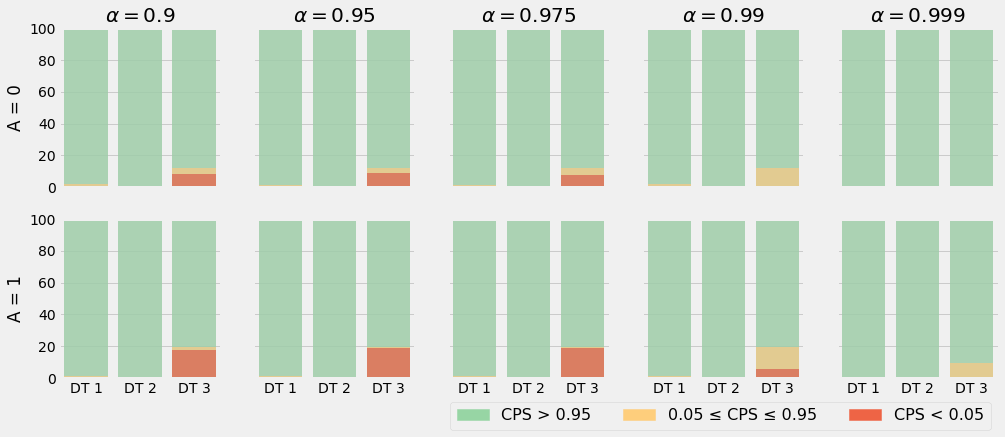

In [423]:
quantiles = [0.90, 0.95, 0.975, 0.99, 0.999]
fig, axs = plt.subplots(2, len(quantiles), figsize=(15,6), sharex=True, sharey=True)
top_bar = mpatches.Patch(color=sns.color_palette("Spectral", 10)[7], label='CPS > 0.95')
med_bar = mpatches.Patch(color=sns.color_palette("Spectral", 10)[3], label='0.05 ≤ CPS ≤ 0.95')
bottom_bar = mpatches.Patch(color=sns.color_palette("Spectral", 10)[1], label='CPS < 0.05')
plt.legend(handles=[top_bar, med_bar, bottom_bar], fontsize=16, ncol=3, bbox_to_anchor=(1.0,-0.1),)

for a in [0,1]:
    for j in range(len(quantiles)):
        plot_stacked_bars(axs[a][j], quantiles[j], a, results_ordered)
        axs[a][j].set_xlabel("")
        axs[a][j].set_ylabel("")
axs[0][0].set_ylabel('A = 0')
axs[1][0].set_ylabel('A = 1')
plt.style.use('fivethirtyeight')
# plt.xlim([0,1.01])


[Text(0.5, 1.0, 'DT 3')]

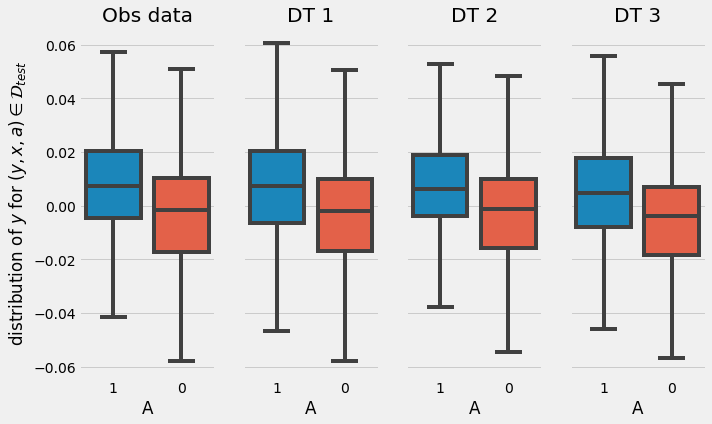

In [191]:
fig, axs = plt.subplots(1, 4, figsize=(10,6), sharey=True)
plt.style.use('fivethirtyeight')
sns.boxplot(y='Pole Angle_t1',x='A', data=results.astype({'A': 'str'}), ax=axs[0], showfliers=False)
axs[0].set(ylabel='distribution of $y$ for $(y,x,a)\in \mathcal{D}_{test}$')
axs[0].set(title='Obs data')

sns.boxplot(y='Sim-1_Pole Angle_t1',x='A', data=results.astype({'A': 'str'}), ax=axs[1], showfliers=False)
axs[1].set(ylabel=None)
axs[1].set(title='DT 1')

sns.boxplot(y='Sim-2_Pole Angle_t1',x='A', data=results.astype({'A': 'str'}), ax=axs[2], showfliers=False)
axs[2].set(ylabel=None)
axs[2].set(title='DT 2')

sns.boxplot(y='Sim-3_Pole Angle_t1',x='A', data=results.astype({'A': 'str'}), ax=axs[3], showfliers=False)
axs[3].set(ylabel=None)
axs[3].set(title='DT 3')



In [98]:
results['$||Y^{sim} - Y^{obs}||^2$ (DT-3)'].max()

2.5000102255035017e-07

[Text(0.5, 1.0, 'DT 3')]

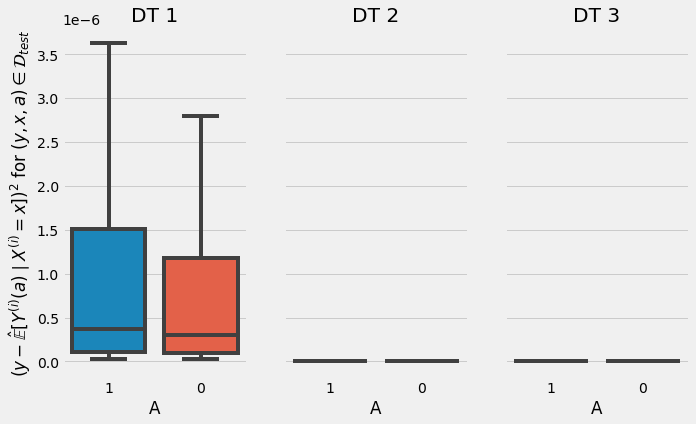

In [424]:
fig, axs = plt.subplots(1, 3, figsize=(10,6), sharey=True)
plt.style.use('fivethirtyeight')
sns.boxplot(y='$||Y^{sim} - Y^{obs}||^2$ (DT-1)',x='A', data=results.astype({'A': 'str'}), ax=axs[0], showfliers=False)
axs[0].set(ylabel='$(y - \hat{\mathbb{E}}[Y^{(i)}(a) \mid X^{(i)}=x])^2$ for $(y, x, a) \in \mathcal{D}_{test}$')
axs[0].set(title='DT 1')

sns.boxplot(y='$||Y^{sim} - Y^{obs}||^2$ (DT-2)',x='A', data=results.astype({'A': 'str'}), ax=axs[1], showfliers=False)
axs[1].set(ylabel=None)
axs[1].set(title='DT 2')

sns.boxplot(y='$||Y^{sim} - Y^{obs}||^2$ (DT-3)',x='A', data=results.astype({'A': 'str'}), ax=axs[2], showfliers=False)
axs[2].set(ylabel=None)
axs[2].set(title='DT 3')



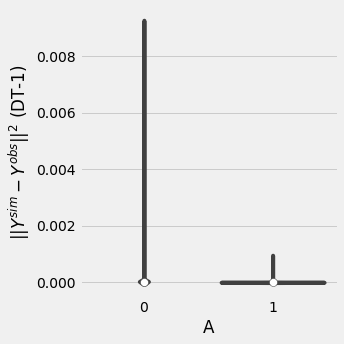

In [1778]:
# fig, axs = plt.subplots(1, 2, figsize=(6,6), sharey=True)
sns.catplot(x="A", y='$||Y^{sim} - Y^{obs}||^2$ (DT-1)',data=results.astype({'A': 'str'}), kind="violin")
# sns.catplot(x="A", y='$||Y^{sim} - Y^{obs}||^2$ (DT-2)',data=results.astype({'A': 'str'}), kind="violin", ax=axs[1])


[Text(0.5, 1.0, 'DT 2')]

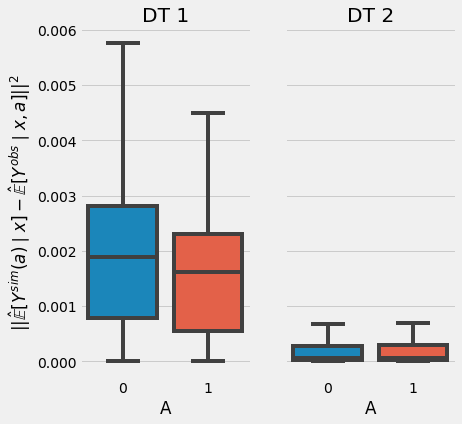

In [63]:
# -0.007
fig, axs = plt.subplots(1, 2, figsize=(6,6), sharey=True)
plt.style.use('fivethirtyeight')
sns.boxplot(y='$||Y^{sim} - Y^{obs}||^2$ (DT-1)',x='A', data=results.astype({'A': 'str'}), ax=axs[0], showfliers=False)
axs[0].set(ylabel='$||\hat{\mathbb{E}}[Y^{sim}(a) \mid x] - \hat{\mathbb{E}}[Y^{obs} \mid x, a]||^2$')
axs[0].set(title='DT 1')
sns.boxplot(y='$||Y^{sim} - Y^{obs}||^2$ (DT-2)',x='A', data=results.astype({'A': 'str'}), ax=axs[1], showfliers=False)
axs[1].set(ylabel=None)
axs[1].set(title='DT 2')
# sns.boxplot(y='$||Y^{sim} - Y^{obs}||^2$ (DT-3)',x='A', data=results.astype({'A': 'str'}), ax=axs[2], showfliers=False)
# axs[2].set(ylabel=None)
# axs[2].set(title='DT 3')

In [258]:
df = pd.DataFrame({'$A$':[0,1], 'CPS':[0.05, 0.95]}).set_index('$A$')
df

,CPS
$A$,
0,0.05
1,0.95


<Figure size 400x200 with 0 Axes>

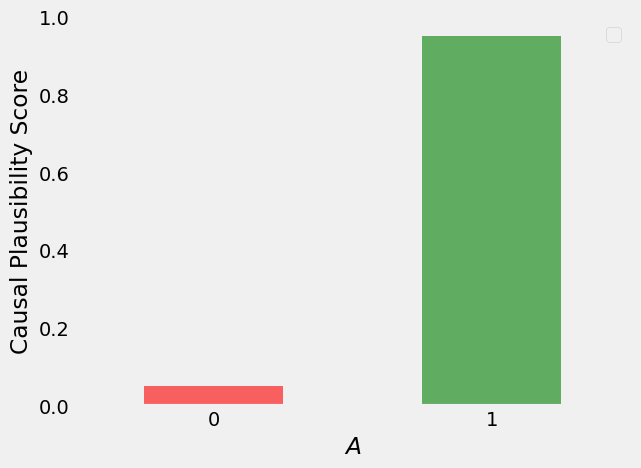

In [285]:
plt.figure(figsize=(4,2))
df.plot.bar(y='CPS', rot=0, alpha=0.6, color=['r','g'])
plt.ylabel('Causal Plausibility Score')
plt.legend([])
plt.ylim([0,1])
plt.grid(False)
plt.style.use('fivethirtyeight')

## Distribution of $\theta = \frac{\mathbb{E}[Y^{\star}\mid x, a] - \mathbb{E}[Y\mid x, a]\mathbb{P}(a\mid x)}{1 - \mathbb{P}(a\mid x)}$

In [1088]:
def theta_distribution_bootstrap():
    obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid-test.csv")
    df_partial = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-iid.csv")
    models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/models-new-x/"
    sim_models_dir = "/data/localhost/not-backed-up/taufiq/Cartpole/models-new-x/"
    obs_data_test['A'] = obs_data_test['A'].astype({'A': 'int'})
    obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()
    
    sim_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=6, n_output=1)
    sim_net.load_state_dict(torch.load(f'{sim_models_dir}/ysim_0'))
    sim_net.eval()
    
    for i in tqdm(range(nreps)):
        policy = PolicyNetwork(input_dim=len(obs_data_test_raw.columns), output_dim=2)
        policy.load_state_dict(torch.load(f'{models_dir}/policy_{i}'))
        policy.eval()
        
        obs_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
        obs_net.load_state_dict(torch.load(f'{models_dir}/yobs_{i}'))
        obs_net.eval()
        
        ymin_90_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
        ymin_90_net.load_state_dict(torch.load(f'{models_dir}/ymin_0.9_{i}'))
        ymin_90_net.eval()
        
        with torch.no_grad():
            X_val = torch.FloatTensor(obs_data_test_raw.values)
            A_val = torch.FloatTensor(obs_data_test['A'].values)
            pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
            Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
            pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
            if i == 0:
                sim_pred = sim_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
                sim2_pred = pred
                sim3_pred = torch.where(pol_val > 0.90, pred + 0.0005, pred)
            df = pd.DataFrame()
            df[f'\theta^{{*}} (DT-1) i={i}'] = ((sim_pred - pred*pol_val)/(1-pol_val)).numpy()
            df[f'\theta^{{*}} (DT-2) i={i}'] = ((sim2_pred - pred*pol_val)/(1-pol_val)).numpy()
            df[f'\theta^{{*}} (DT-3) i={i}'] = ((sim3_pred - pred*pol_val)/(1-pol_val)).numpy()
            obs_data_test = pd.concat([obs_data_test, df], axis=1)
    return obs_data_test 

In [1089]:
theta_dist = theta_distribution_bootstrap()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.14it/s]


In [1122]:
def get_percentile(alpha, df):
    res = pd.DataFrame()
    for DT in [1, 2, 3]:
        res[f'Quantile (DT-{DT})'] = df[[f'\theta^{{*}} (DT-{DT}) i={i}' for i in range(nreps)]].apply(lambda x: np.percentile(x, alpha), axis=1)
    return res

In [1097]:
percentiles = get_percentile(0.05, theta_dist)
percentiles.head()

,lower quantile (DT-1),upper quantile (DT-1),lower quantile (DT-2),upper quantile (DT-2),lower quantile (DT-3),upper quantile (DT-3)
0,0.037452,0.037543,0.036319,0.036342,0.044132,0.044216
1,0.000511,0.000538,0.000294,0.000319,0.000294,0.000319
2,-0.026033,-0.026011,-0.027466,-0.027291,-0.027466,-0.027291
3,0.013098,0.013150,0.012488,0.012497,0.012488,0.012497
4,0.001532,0.001729,0.000657,0.000821,0.000657,0.000821


In [1132]:
results[(results['$\hat{p}^{x,a}$ (DT-3)']>0.95) & (results['quantile'] == 0.90)]

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t,Cart Position_t1,Pole Angle_t1,$||Y^{sim} - Y^{obs}||^2$ (DT-1),...,ymin,ymax,pol_val,LB,UB,Sim-1_Pole Angle_t1,Sim-2_Pole Angle_t1,Sim-3_Pole Angle_t1,Bound length,quantile
1,1,-1.503026,-0.140571,-0.001680,0.102165,11.0,387.0,-1.505837,0.000364,4.008536e-09,...,-0.004477,0.004496,0.711089,-0.001035,0.001558,0.000427,0.000364,0.000364,0.002592,0.9
2,1,-1.296141,-0.147858,-0.031576,0.218185,15.0,463.0,-1.299098,-0.027213,1.168483e-07,...,-0.031943,-0.022808,0.752128,-0.028381,-0.026117,-0.026865,-0.027207,-0.027207,0.002264,0.9
3,1,-0.718634,-0.601867,0.007465,0.259945,17.0,103.0,-0.730671,0.012664,4.475694e-09,...,0.007702,0.016660,0.894635,0.012141,0.013085,0.012730,0.012663,0.012663,0.000944,0.9
4,1,-0.482321,-0.602832,-0.004788,0.289486,19.0,97.0,-0.494377,0.001002,8.962649e-09,...,-0.003908,0.005125,0.893622,0.000479,0.001440,0.001096,0.001002,0.001002,0.000961,0.9
6,0,-0.910509,-0.196090,0.014028,-0.194395,36.0,117.0,-0.914430,0.010140,7.170783e-10,...,0.005494,0.014178,0.804973,0.009235,0.010928,0.010168,0.010141,0.010141,0.001694,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,-1.527100,-0.211357,0.001888,0.168100,49958.0,423.0,-1.531327,0.005250,4.264110e-09,...,0.000362,0.009329,0.822802,0.004384,0.005973,0.005316,0.005251,0.005251,0.001589,0.9
9996,1,-1.367233,0.036268,-0.010585,-0.025786,49971.0,340.0,-1.366508,-0.011101,1.034485e-06,...,-0.015836,-0.006843,0.360533,-0.014129,-0.008378,-0.012117,-0.011100,-0.011100,0.005751,0.9
9997,0,0.058185,-0.031586,-0.075140,-0.144613,49973.0,28.0,0.057553,-0.078032,1.180684e-08,...,-0.082216,-0.073048,0.848940,-0.078672,-0.077287,-0.078150,-0.078041,-0.078041,0.001385,0.9
9998,0,-0.378724,-0.495700,0.034195,-0.081246,49974.0,61.0,-0.388638,0.032570,3.066517e-08,...,0.027773,0.036364,0.478878,0.030070,0.034547,0.032745,0.032570,0.032570,0.004477,0.9


In [1141]:

# results.columns
quantiles_ub_1 = []
quantiles_ub_2 = []
quantiles_ub_3 = []

quantiles_lb_1 = []
quantiles_lb_2 = []
quantiles_lb_3 = []

for i in tqdm(np.linspace(0.0, 1.0, 21)):
    res = get_percentile(1 - i/2, theta_dist.iloc[[1]])
    quantiles_ub_1.append(res[f'Quantile (DT-1)'].values[0])
    quantiles_ub_2.append(res[f'Quantile (DT-2)'].values[0])
    quantiles_ub_3.append(res[f'Quantile (DT-3)'].values[0])
    res = get_percentile(i/2, theta_dist.iloc[[1]])
    quantiles_lb_1.append(res[f'Quantile (DT-1)'].values[0])
    quantiles_lb_2.append(res[f'Quantile (DT-2)'].values[0])
    quantiles_lb_3.append(res[f'Quantile (DT-3)'].values[0])
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 82.59it/s]


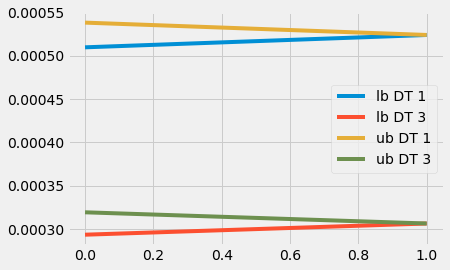

In [1153]:
plt.plot(np.linspace(0.0, 1.0, 21), quantiles_lb_1, label='lb DT 1')
# plt.plot(np.linspace(0.0, 1.0, 21), quantiles_lb_2, label='lb DT 2')
plt.plot(np.linspace(0.0, 1.0, 21), quantiles_lb_3, label='lb DT 3')

plt.plot(np.linspace(0.0, 1.0, 21), quantiles_ub_1, label='ub DT 1')
# plt.plot(np.linspace(0.0, 1.0, 21), quantiles_ub_2, label='ub DT 2')
plt.plot(np.linspace(0.0, 1.0, 21), quantiles_ub_3, label='ub DT 3')


plt.legend()